# Annotation of thymus data

Zoë Steier

* Annotate all cells in the full thymus dataset. 
* Annotate the positive selection subset.

## Imports and settings

In [146]:
# Import required packages
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import anndata
import scanpy as sc
import umap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%matplotlib inline

In [2]:
# Imports for totalVI
import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData, Dataset10X
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer
import torch
scvi.set_seed(0)

# GPU settings
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [3]:
# Plotting settings
sns.set(context="notebook", font_scale=1.3, style="ticks")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

## Load data

In [4]:
# Load full dataset
adata_full = anndata.read("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable/posterior_adata.h5ad")

In [5]:
adata_full

AnnData object with n_obs × n_vars = 72042 × 5125
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins', 'batch', 'leiden_totalVI_res1.4', 'leiden_totalVI_res1.0', 'leiden_totalVI_res0.6', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', 'ADT_CD14_A0424_fore_prob', 'ADT_CD14_A0424', 'ADT_CD15(SSEA-1)_A

## Annotate full dataset

### Generate annotations

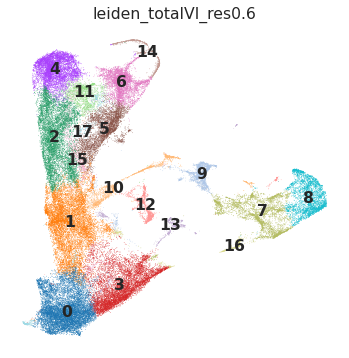

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot clustering resolution 0.6 for annotation
fig, ax = plt.subplots(figsize=(6, 6))

sc.pl.umap(
    adata_full, 
    color=["leiden_totalVI_res0.6"],
    ncols=1,
    legend_loc = "on data",
    ax = ax,
    frameon = False
)

plt.tight_layout()

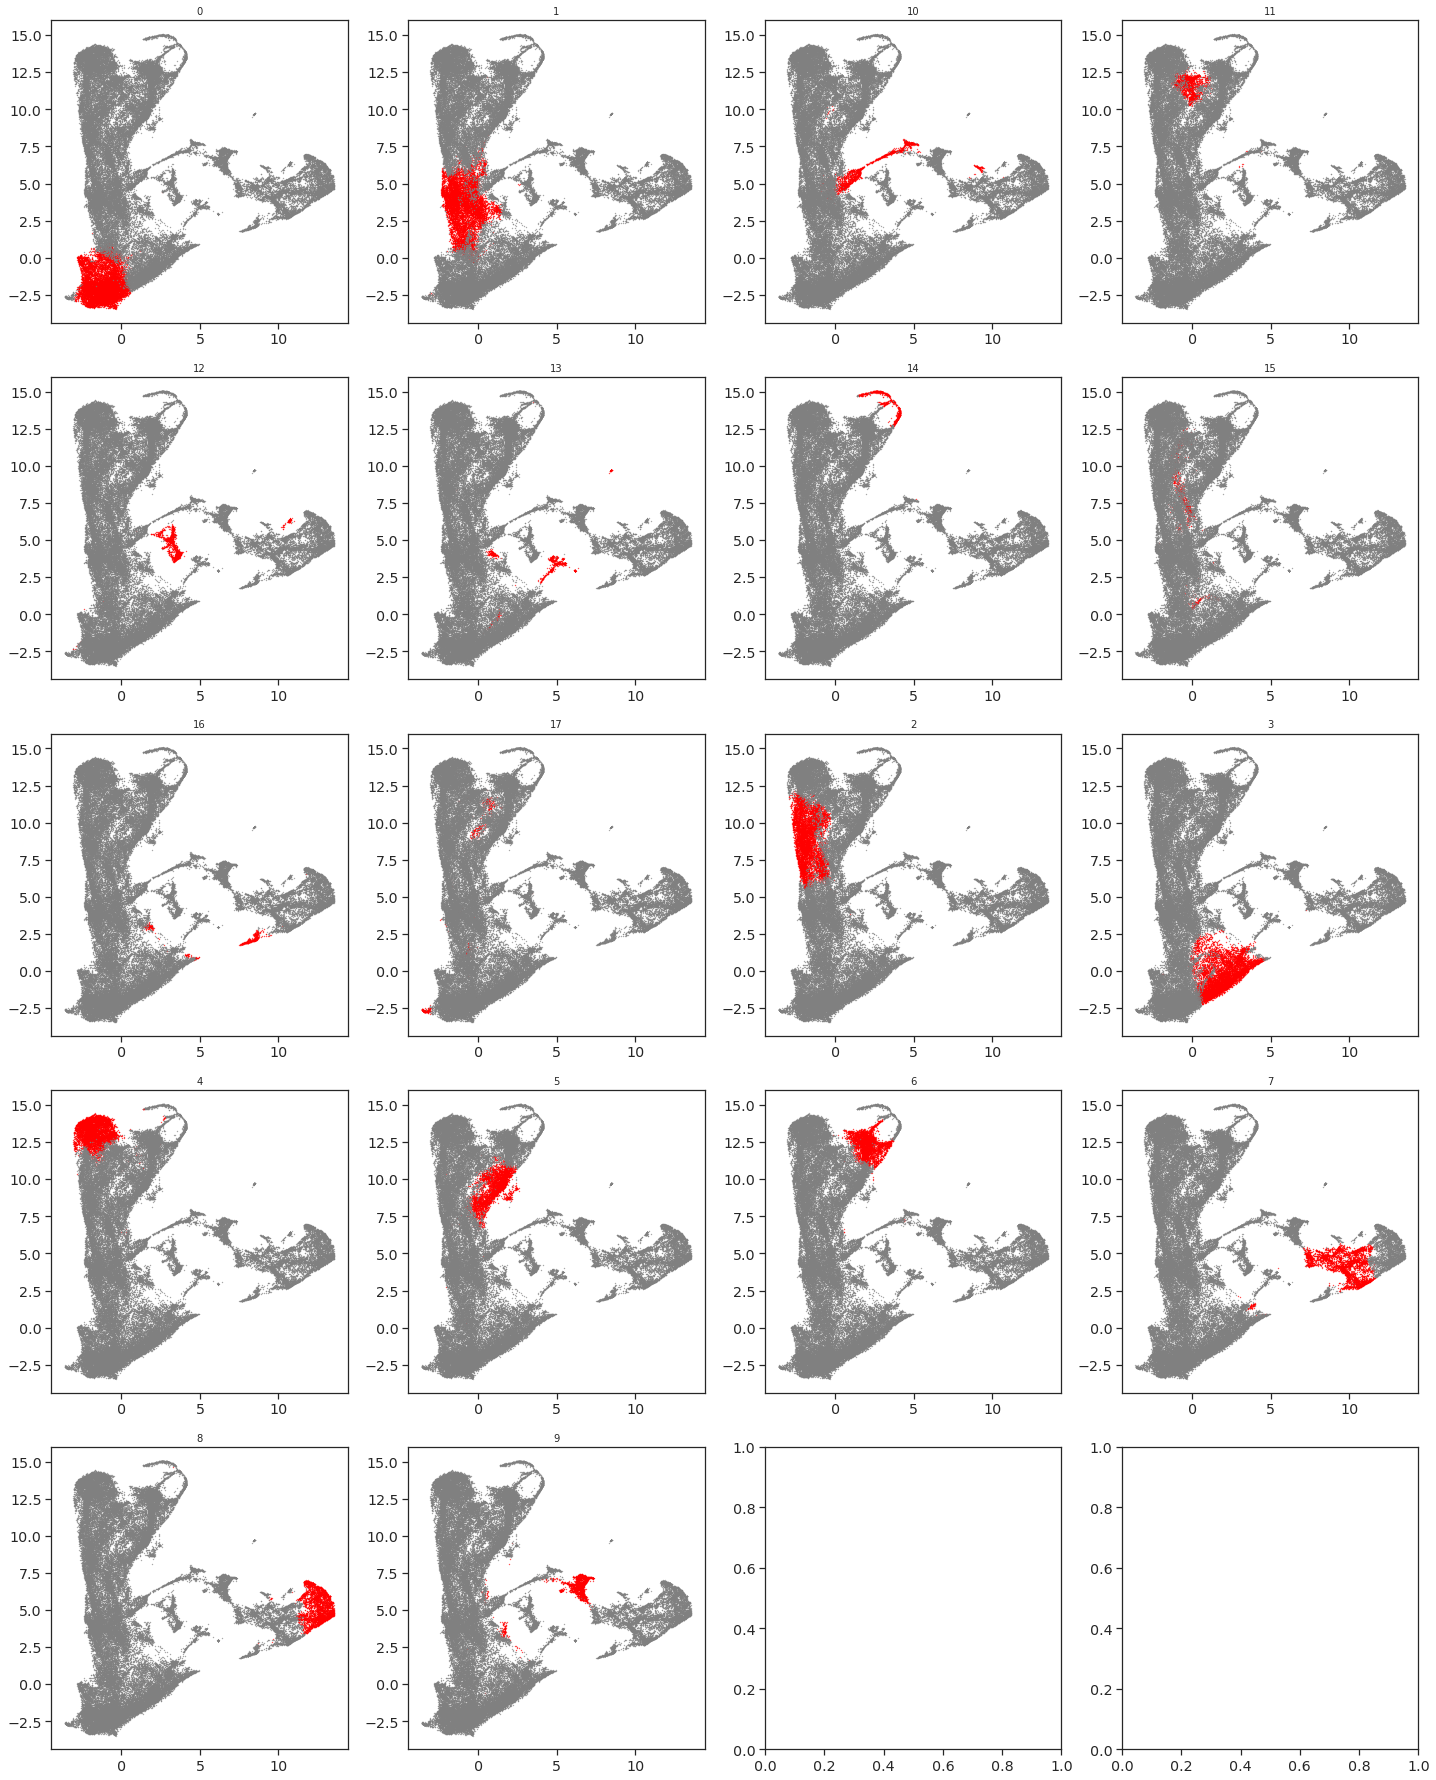

In [19]:
# Plot each cluster independently

fig, ax = plt.subplots(5, 4, figsize=(20, 25))
clusters = np.array((adata_full.obs["leiden_totalVI_res0.6"])).ravel()
for c in range(len(np.unique(clusters))):
    ax.flat[c].scatter(x = adata_full.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 0], y = adata_full.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 1], s=.1,
                      c = "red")
    ax.flat[c].scatter(x = adata_full.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 0], y = adata_full.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 1], s=.1,
                      c = "grey")
    ax.flat[c].set_title(str(np.unique(clusters)[c]), fontsize = 10)

plt.tight_layout()

In [7]:
# Subcluster 10 (negative selection, NKT)
sc.tl.leiden(adata_full, restrict_to = ("leiden_totalVI_res0.6", ["10"]), key_added="leiden_NKT_sub_0.05", resolution=0.05)

# NKT: Klrb1a, Nkg7, Klrd1
# Negative selection: Pdcd1, Ikzf2, Bcl2l11, Nr4a1

In [8]:
# Subcluster 2 (semimature CD4, semimature CD8 (like res1.4 cluster 13))
sc.tl.leiden(adata_full, restrict_to = ("leiden_NKT_sub_0.05", ["2"]), key_added="leiden_semimature", resolution=0.3)

# Runx3

In [30]:
# Subcluster 13 (Myeloid, erythrocyte, B cells)
sc.tl.leiden(adata_full, restrict_to = ("leiden_semimature", ["13"]), key_added="leiden_myeloid", resolution=0.3)

# Split into three: B, Erythrocyte, Myeloid

In [64]:
# Subcluster 7,8 (DN and early DP)
sc.tl.leiden(adata_full, restrict_to = ("leiden_myeloid", ["7", "8"]), key_added="leiden_DN", resolution=0.15)

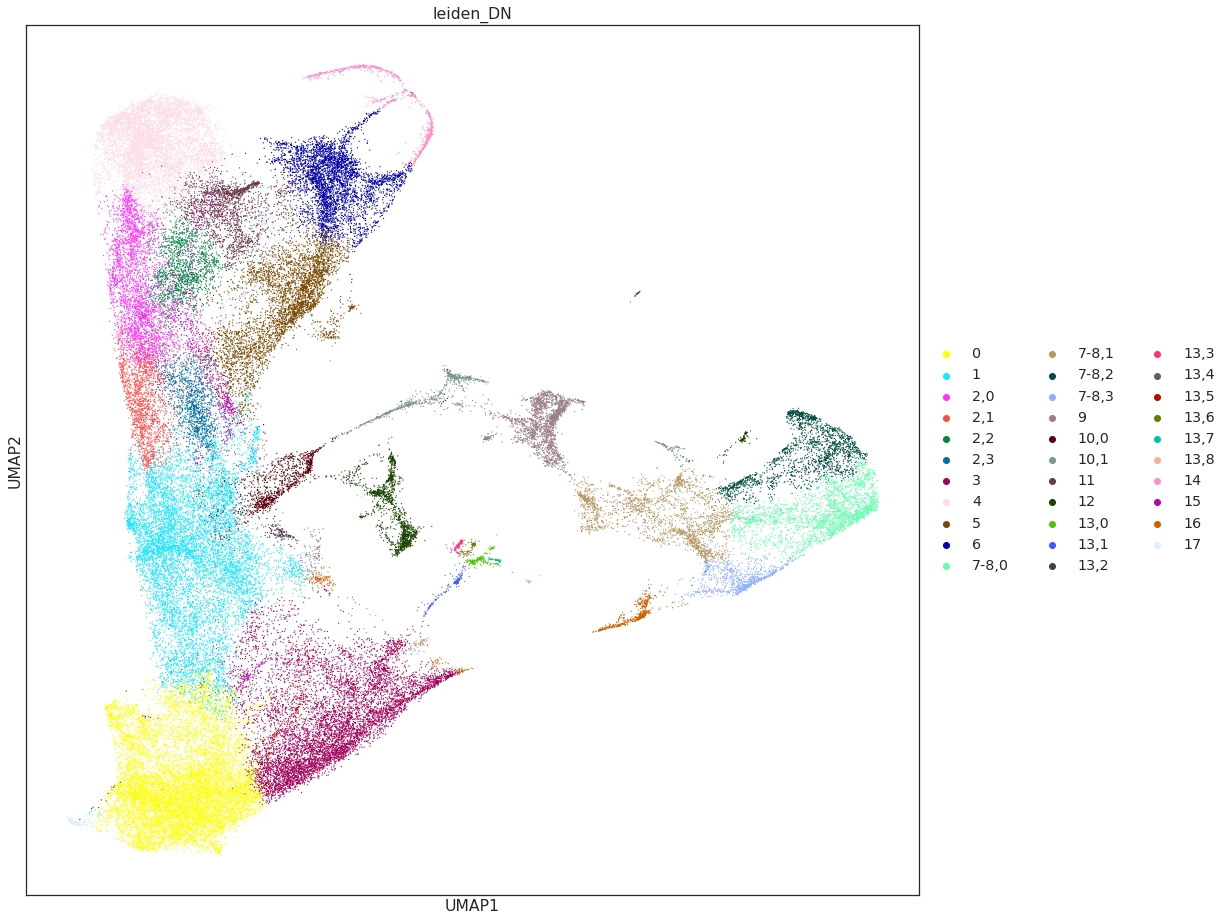

In [65]:
# Plot subclusterings

fig, ax = plt.subplots(figsize=(16, 16))
sc.pl.umap(
    adata_full, 
    color= ["leiden_DN"], 
    ax = ax,
    s = 6
)

IndexError: index 28 is out of bounds for axis 0 with size 28

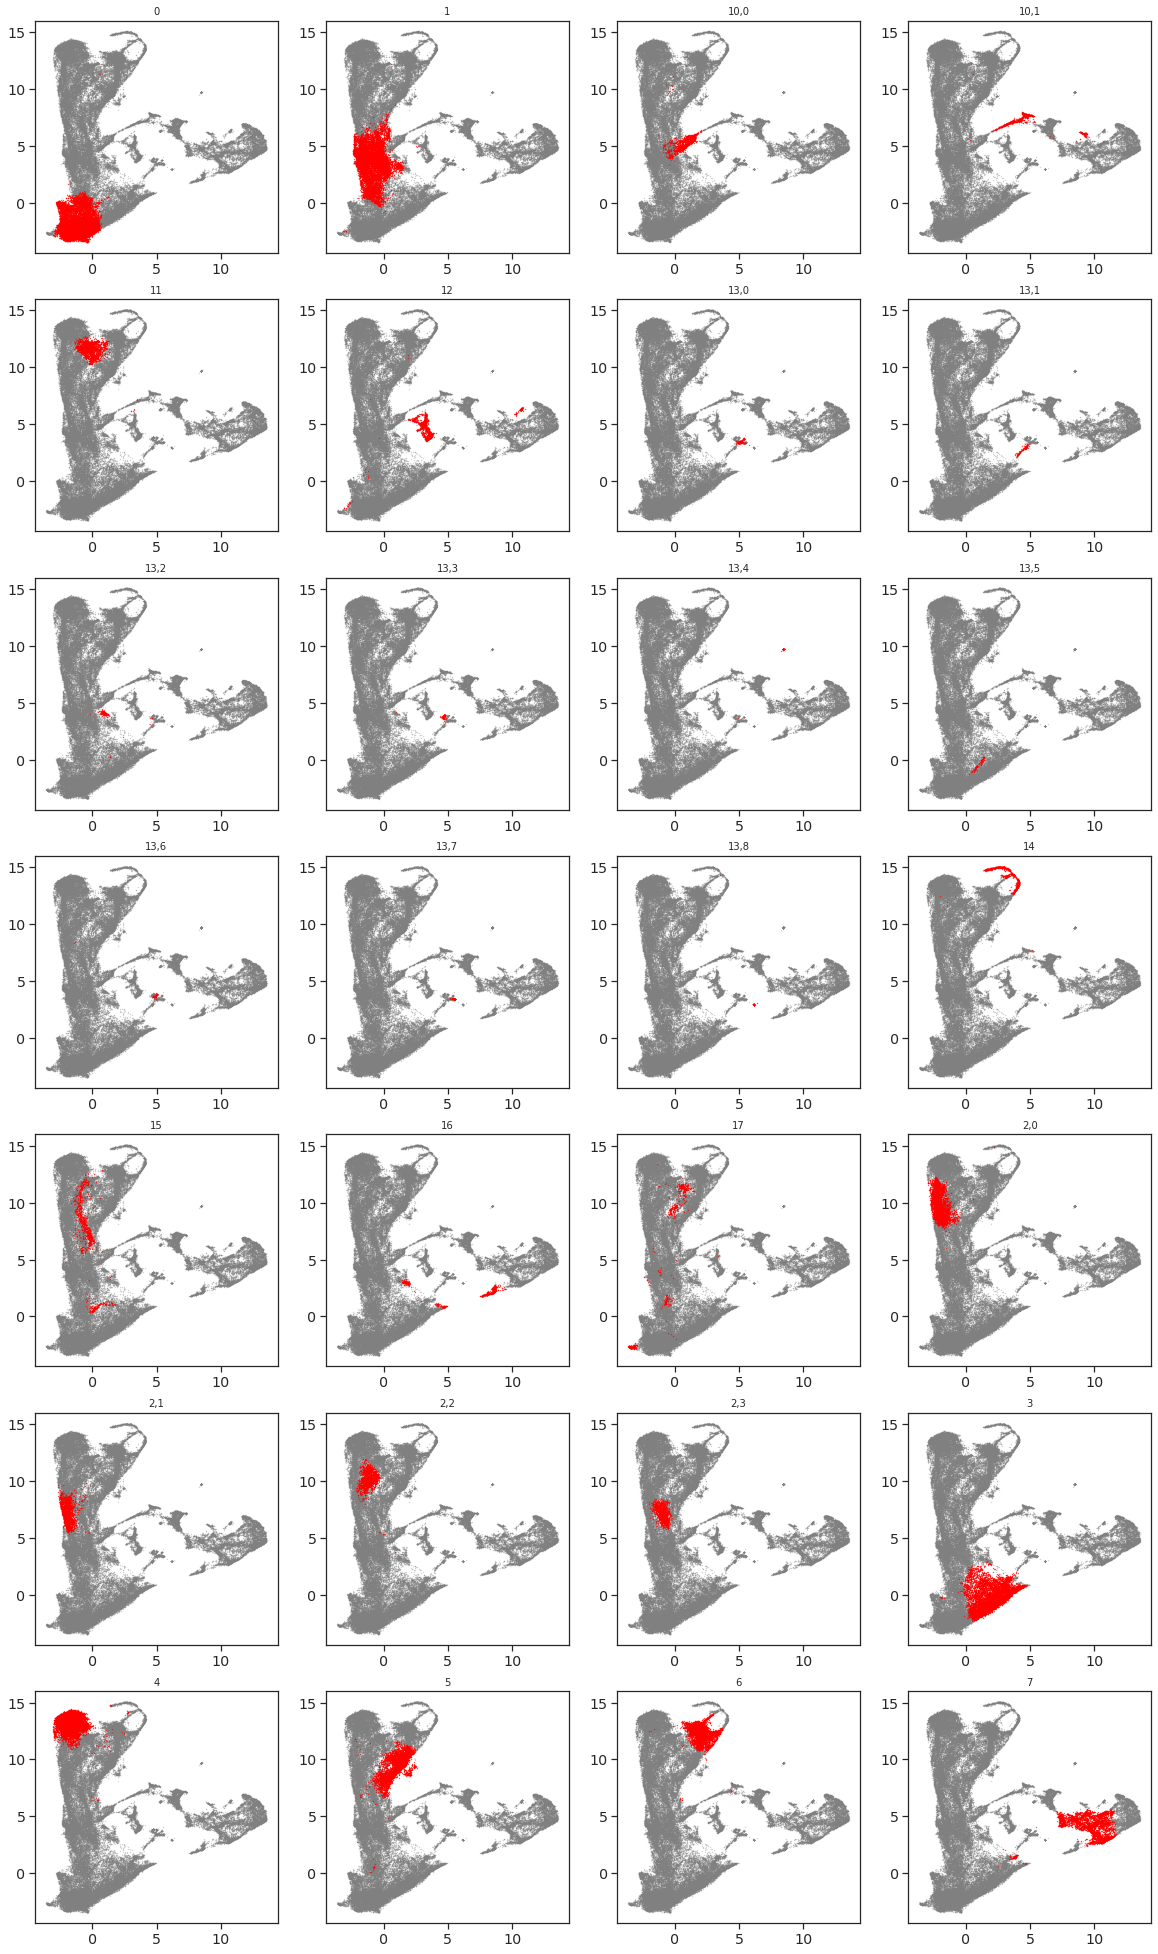

In [34]:
# Plot subclusters
fig, ax = plt.subplots(8, 4, figsize=(20, 40))
clusters = np.array((adata_full.obs["leiden_myeloid"])).ravel()
for c in range(len(np.unique(clusters))):

    ax.flat[c].scatter(x = adata_full.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 0], y = adata_full.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 1], s=.1,
                      c = "grey", alpha = 0.5)
    ax.flat[c].scatter(x = adata_full.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 0], y = adata_full.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 1], s=.1,
                      c = "red")
    ax.flat[c].set_title(str(np.unique(clusters)[c]), fontsize = 10)

plt.tight_layout()

In [7]:
# Make dictionary of annotations for plotting

annotations_full = {
              "0": "DP (Q2)", # Rag+, Cd52
              "1": "DP (Sig.)",
              "2,0": "Immature\n CD4", 
              "2,1": "Immature\n CD4",
              "2,2": "Neg. sel.\n (2)", # Ikzf2, Bcl2l11, 
              "2,3": "Immature\n CD8", # Outlier from the rest of cluster 2 due to Runx3 expression      
              "3": "DP (Q1)", # Rag+, Ly6d
              "4": "Mature\n CD4", # CD55, CD62L
              "5": "Immature\n CD8", 
              "6": "Mature\n CD8", 
              "7-8,0": "DP (P)",
              "7-8,1": "DN",
              "7-8,2": "DP (P)",
              "7-8,3": "DP (P)",
              "9": "GD T",
              "10,0": "Neg. sel.\n (1)", # Negative selection: Pdcd1, Ikzf2, Bcl2l11, Nr4a1
              "10,1": "NKT", # NKT: Klrb1a, Nkg7, Klrd1
              "11": "Treg",
              "12": "Dying",
    
              "13,0": "Myeloid", # DC: Itgax, Monocyte: Ly6c2, pDC: SiglecH
              "13,1": "Myeloid", # Macrophage: C1qa, C1qb, Vcam1, Mafb
              "13,2": "Myeloid",
              "13,3": "Myeloid", # Migratory DC: Anxa3, Cacnb3
              "13,4": "B", # CD19
              "13,5": "Myeloid",
              "13,6": "Myeloid",
              "13,7": "Myeloid", # Neutrophil: S100a8, Monocyte: Ly6c2
              "13,8": "Erythrocyte",

              "14": "Mature\n cycling", # Stmn1, Top2a, H2-K1
              "15": "Interferon\n sig.", # Interferon signature
              "16": "DP (Q1)",
              "17": "Doublet"
              }

In [8]:
# Make dictionary of annotations 

annotations_clean = {
              "0": "DP (Q2)",
              "1": "DP (Sig.)",
              "2,0": "Immature CD4", 
              "2,1": "Immature CD4", 
              "2,2": "Neg. sel. (2)", 
              "2,3": "Immature CD8",     
              "3": "DP (Q1)",
              "4": "Mature CD4",
              "5": "Immature CD8", 
              "6": "Mature CD8", 
              "7-8,0": "DP (P)",
              "7-8,1": "DN",
              "7-8,2": "DP (P)",
              "7-8,3": "DP (P)",
              "9": "GD T",
              "10,0": "Neg. sel. (1)", 
              "10,1": "NKT", 
              "11": "Treg",
              "12": "Dying",
    
              "13,0": "Myeloid", 
              "13,1": "Myeloid", 
              "13,2": "Myeloid",
              "13,3": "Myeloid", 
              "13,4": "B", 
              "13,5": "Myeloid",
              "13,6": "Myeloid",
              "13,7": "Myeloid", 
              "13,8": "Erythrocyte",

              "14": "Mature cycling",
              "15": "Interferon sig.", 
              "16": "DP (Q1)",
              "17": "Doublet"
              }

In [11]:
len(annotations_full)

32

### Save full data annotations

In [13]:
# Save the results in a dataframe: cluster number, label
annotation_sub = adata_full.obs["leiden_DN"]

In [10]:
labels = pd.Series([annotations_full[c] for c in adata_full.obs["leiden_DN"]], dtype = "category")
labels.cat.categories

Index(['B', 'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)', 'Doublet',
       'Dying', 'Erythrocyte', 'GD T', 'Immature\n CD4', 'Immature\n CD8',
       'Interferon\n sig.', 'Mature\n CD4', 'Mature\n CD8', 'Mature\n cycling',
       'Myeloid', 'NKT', 'Neg. sel.\n (1)', 'Neg. sel.\n (2)', 'Treg'],
      dtype='object')

In [11]:
# Create labels
labels = labels.astype(pd.api.types.CategoricalDtype(categories=['DN', 'DP (Q1)', 'Neg. sel.\n (2)', 'DP (P)', 'DP (Sig.)', 'Doublet',
       'Dying', 'Erythrocyte', 'GD T', 'Immature\n CD4', 'Immature\n CD8',
       'Interferon\n sig.', 'Mature\n CD4', 'Mature\n CD8',
       'Mature\n cycling', 'Myeloid', 'NKT', 'Neg. sel.\n (1)',
       'DP (Q2)', 'Treg', 'B'], ordered=True))

In [14]:
annot_df = pd.DataFrame({'leiden_subclusters': pd.Series(annotation_sub.values), 
                         'labels':pd.Series(labels)})

In [15]:
annot_df

leiden_subclusters           labels
0                     11             Treg
1                    2,2  Neg. sel.\n (2)
2                      4     Mature\n CD4
3                      3          DP (Q1)
4                      1        DP (Sig.)
...                  ...              ...
72037                2,0   Immature\n CD4
72038                  3          DP (Q1)
72039                2,0   Immature\n CD4
72040                  1        DP (Sig.)
72041              7-8,1               DN

[72042 rows x 2 columns]

In [16]:
# Update anndata object
adata_full.obs["annotations"] = labels.values

In [17]:
# Update with clean annotations
annotation_sub = adata_full.obs["leiden_DN"]
labels_clean = [annotations_clean[c] for c in adata_full.obs["leiden_DN"]]
annot_df = pd.DataFrame({'leiden_subclusters': pd.Series(annotation_sub.values), 
                         'labels':pd.Series(labels_clean)})
annot_df

leiden_subclusters         labels
0                     11           Treg
1                    2,2  Neg. sel. (2)
2                      4     Mature CD4
3                      3        DP (Q1)
4                      1      DP (Sig.)
...                  ...            ...
72037                2,0   Immature CD4
72038                  3        DP (Q1)
72039                2,0   Immature CD4
72040                  1      DP (Sig.)
72041              7-8,1             DN

[72042 rows x 2 columns]

In [18]:
adata_full.obs["annotations_clean"] = labels_clean

In [19]:
include_cells = [c not in ["Doublet"] for c in adata_full.obs["annotations"]]

In [75]:
os.getcwd()

'/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus'

In [ ]:
# Save anndata object
adata_full.write("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/post_adata_annotated.h5ad")

In [13]:
# Save annotation information for Vision
save_path = '/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/'
annot_df.to_csv(save_path + "annotations.csv.gz")

### Read annotated data and plot

In [6]:
# Read anndata
adata_full = anndata.read("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/post_adata_annotated.h5ad")

In [20]:
include_cells = [c not in ["Doublet"] for c in adata_full.obs["annotations"]]

In [21]:
adata_full.obs["annotations"]

AAACCCAAGACTACCT-1-0               Treg
AAACCCAAGGACATCG-1-0    Neg. sel.\n (2)
AAACCCACATTCTCCG-1-0       Mature\n CD4
AAACGAACACGCTGCA-1-0            DP (Q1)
AAACGCTGTCAACACT-1-0          DP (Sig.)
                             ...       
TTTGATCTCACCTACC-8-1     Immature\n CD4
TTTGGAGCAGACCTGC-8-1            DP (Q1)
TTTGGTTTCGACCATA-8-1     Immature\n CD4
TTTGTTGAGTTTGAGA-8-1          DP (Sig.)
TTTGTTGGTGTTCGAT-8-1                 DN
Name: annotations, Length: 72042, dtype: category
Categories (21, object): ['DN' < 'DP (Q1)' < 'Neg. sel.\n (2)' < 'DP (P)' ... 'Neg. sel.\n (1)' < 'DP (Q2)' < 'Treg' < 'B']

Trying to set attribute `.obs` of view, copying.
... storing 'annotations_clean' as categorical


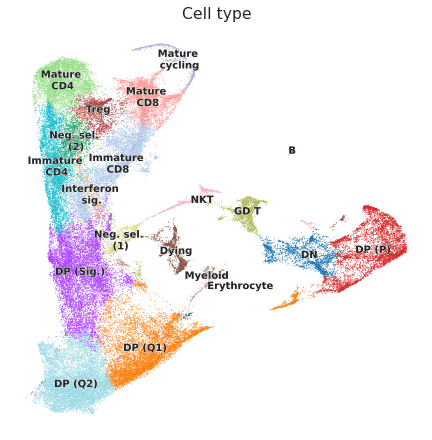

In [26]:
# Plot annotations on UMAP and save
fig, ax = plt.subplots(figsize=(7.5, 7.5))

sc.pl.umap(
    adata_full[include_cells], 
    color=["annotations"],
    ncols=1,
    legend_loc = "on data",
    ax = ax,
    frameon = False,
    legend_fontsize="medium",
    title = "Cell type",
    legend_fontoutline = .8,
    s = 3
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_celltype.pdf", 
          dpi=DPI, bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
... storing 'annotations_clean' as categorical


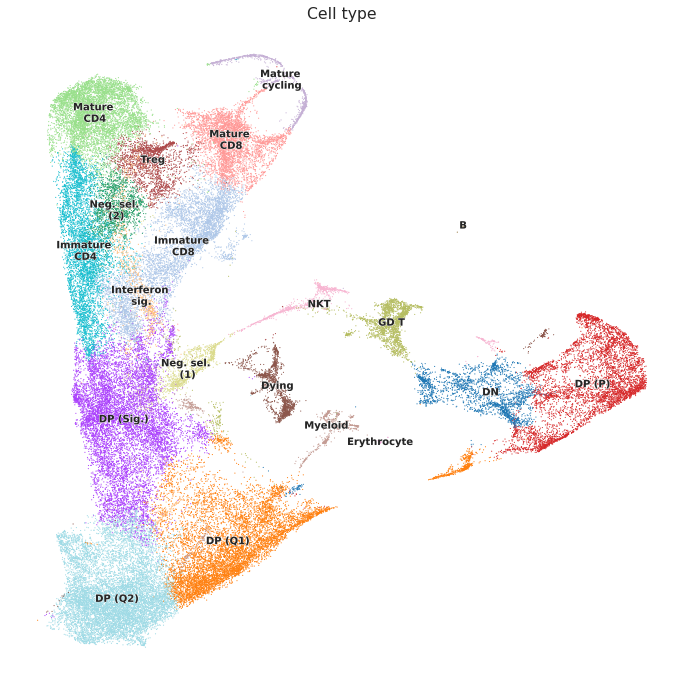

In [25]:
# Plot annotations to view
fig, ax = plt.subplots(figsize=(12, 12))

sc.pl.umap(
    adata_full[include_cells], 
    color=["annotations"],
    ncols=1,
    legend_loc = "on data",
    ax = ax,
    frameon = False,
    legend_fontsize="medium",
    title = "Cell type",
    legend_fontoutline = .8,
    s = 5,
    show = True
)

### Generate genotype annotations

In [27]:
metadata = pd.read_csv("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/metadata/Metadata_SeqStats_totalSeq_experiments.csv")
metadata = metadata[metadata["Tissue"] == "thymus"]
metadata = metadata[metadata["TotalSeq_panel"] == "ADT111"]
metadata

Sample Genotype Experiment Replicate   Location  \
0             ZRS06_1_B6_r1       B6      ZRS06        r1   Berkeley   
1            ZRS06_2_AND_r1      AND      ZRS06        r1   Berkeley   
2             ZRS06_3_F5_r1       F5      ZRS06        r1   Berkeley   
3             ZRS07_1_B6_r2       B6      ZRS07        r2   Berkeley   
4            ZRS07_2_B2M_r1      B2M      ZRS07        r1   Berkeley   
5            ZRS07_3_B2M_r2      B2M      ZRS07        r2   Berkeley   
6            ZRS07_4_AND_r2      AND      ZRS07        r2   Berkeley   
7             ZRS07_5_B6_r3       B6      ZRS07        r3   Berkeley   
8           ZRS07_6_MHC2_r1     MHC2      ZRS07        r1   Berkeley   
9           ZRS07_7_MHC2_r2     MHC2      ZRS07        r2   Berkeley   
10            ZRS07_8_F5_r2       F5      ZRS07        r2   Berkeley   
11    ZRS08_1_B6_thy_r4_111       B6      ZRS08        r4  BioLegend   
12    ZRS08_2_B6_thy_r4_111       B6      ZRS08        r4  BioLegend   
13   ZRS08_3_OT1_thy_r1_111      OT1      ZRS08        r1  BioLegend   
14   ZRS08_4_OT2_thy_r1_111      OT2      ZRS08        r1  BioLegend   
18    ZRS08_8_B6_thy_r5_111       B6      ZRS08        r5  BioLegend   
19    ZRS08_9_B6_thy_r5_111       B6      ZRS08        r5  BioLegend   
20  ZRS08_10_OT1_thy_r2_111      OT1      ZRS08        r2  BioLegend   
21  ZRS08_11_OT2_thy_r2_111      OT2      ZRS08        r2  BioLegend   

        Date  Batch Species  Tissue  Gender  FACS_sort TotalSeq_panel  \
0   20190513      1   mouse  thymus  female  CD5+TCRB+         ADT111   
1   20190513      2   mouse  thymus  female        NaN         ADT111   
2   20190513      3   mouse  thymus  female        NaN         ADT111   
3   20190625      4   mouse  thymus  female  CD5+TCRB+         ADT111   
4   20190625      5   mouse  thymus  female  CD5+TCRB+         ADT111   
5   20190625      6   mouse  thymus  female  CD5+TCRB+         ADT111   
6   20190625      7   mouse  thymus  female        NaN         ADT111   
7   20190702      8   mouse  thymus  female  CD5+TCRB+         ADT111   
8   20190702      9   mouse  thymus  female  CD5+TCRB+         ADT111   
9   20190702     10   mouse  thymus  female  CD5+TCRB+         ADT111   
10  20190702     11   mouse  thymus  female        NaN         ADT111   
11  20190731     12   mouse  thymus  female        NaN         ADT111   
12  20190731     13   mouse  thymus  female        NaN         ADT111   
13  20190731     14   mouse  thymus  female        NaN         ADT111   
14  20190731     15   mouse  thymus  female        NaN         ADT111   
18  20190731     19   mouse  thymus  female        NaN         ADT111   
19  20190801     20   mouse  thymus  female        NaN         ADT111   
20  20190801     21   mouse  thymus  female        NaN         ADT111   
21  20190801     22   mouse  thymus  female        NaN         ADT111   

               Cellranger_name  Cells  RNA_mean_reads_per_cell  \
0        ZRS06_1_B6_cellranger   3118                   111054   
1       ZRS06_2_AND_cellranger   2750                   130027   
2        ZRS06_3_F5_cellranger   2676                   124718   
3     ZRS07_1_B6_r2_cellranger   4831                   125635   
4    ZRS07_2_B2M_r1_cellranger   4476                   143974   
5    ZRS07_3_B2M_r2_cellranger   3984                   155741   
6    ZRS07_4_AND_r2_cellranger   4518                   138462   
7     ZRS07_5_B6_r3_cellranger   2550                   217677   
8   ZRS07_6_MHC2_r1_cellranger   3688                   166871   
9   ZRS07_7_MHC2_r2_cellranger   5711                   109954   
10    ZRS07_8_F5_r2_cellranger   4681                   133259   
11             1_B6_thy_r4_111   4473                    68136   
12             2_B6_thy_r4_111   9408                    34457   
13            3_OT1_thy_r1_111   4779                    42359   
14            4_OT2_thy_r1_111   6627                    37688   
18             8_B6_thy_r5_111   5403                    60641 

In [28]:
Genotypes_by_batch = metadata["Genotype"].values

In [29]:
Genotypes_by_batch = ['B6', 'AND', 'F5', 'B6', 'MHCI-/-', 'MHCI-/-', 'AND', 'B6', 'MHCII-/-', 'MHCII-/-',
       'F5', 'B6', 'B6', 'OT-I', 'OT-II', 'B6', 'B6', 'OT-I', 'OT-II']

In [30]:
genotype = pd.Series([Genotypes_by_batch[int(batch)] for batch in adata_full.obs["batch_indices"].values])

In [31]:
from pandas.api.types import CategoricalDtype
genotype = genotype.astype(CategoricalDtype(categories=["B6", "AND", "OT-II", "MHCI-/-", "F5", "OT-I", "MHCII-/-"], ordered=True))

In [32]:
adata_full.obs["Genotype"] = genotype.values

In [33]:
adata_full.obs["Genotype"].cat.categories

Index(['B6', 'AND', 'OT-II', 'MHCI-/-', 'F5', 'OT-I', 'MHCII-/-'], dtype='object')

In [34]:
# Genotypes color palette
genotype_colors = {"B6": "#cab2d6", 
                   "AND": "#f4a582", 
                   "OT-II": "#d6604d", 
                   "MHCI-/-": "#b2182b", 
                   "F5": "#92c5de", 
                   "OT-I": "#4393c3", 
                   "MHCII-/-": "#2166ac", 
                  }

In [35]:
genotype_palette = [genotype_colors[genotype] for genotype in adata_full.obs["Genotype"].cat.categories]

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'annotations_clean' as categorical


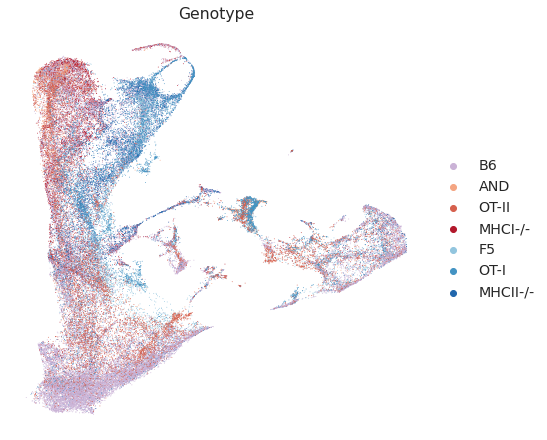

In [36]:
# Plot genotypes to save
fig, ax = plt.subplots(figsize=(7.5, 7.5))

sc.pl.umap(
    adata_full[include_cells], 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    frameon = False,
    title = "Genotype",
    s = 3,
    palette = genotype_palette
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_genotype.pdf", 
           dpi=DPI, bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
... storing 'annotations_clean' as categorical


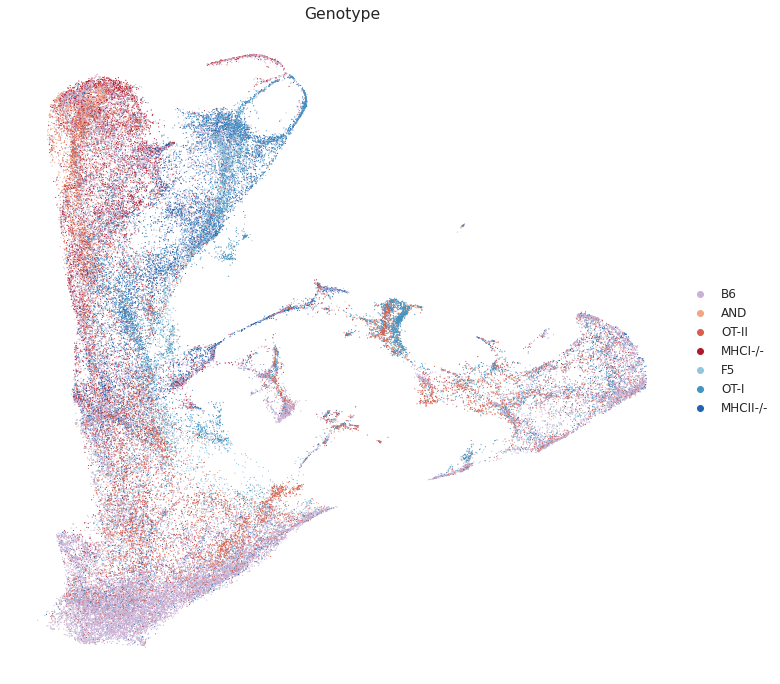

In [37]:
# Plot genotypes to view
fig, ax = plt.subplots(figsize=(12, 12))

sc.pl.umap(
    adata_full[include_cells], 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    frameon = False,
    legend_fontsize="large",
    title = "Genotype",
    s = 5,
    palette = genotype_palette
)

## Annotate positive selection subset

### Load and prepare data

In [147]:
# Read anndata
adata_pos = anndata.read("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable_posselecting/posterior_adata.h5ad")

In [151]:
# Something weird happened to the colors - restore them by deleting and replotting
del adata_pos.uns["leiden_totalVI_res0.6_colors"]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

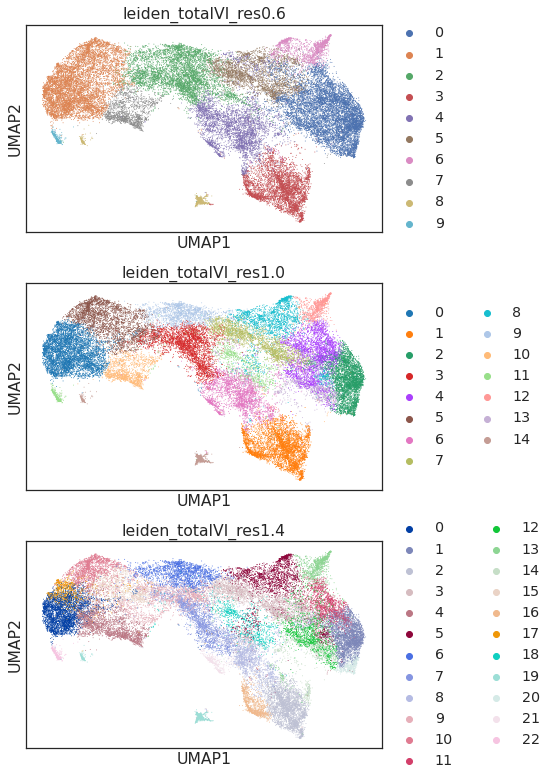

In [152]:
# Plot clusters to annotate
sc.pl.umap(
    adata_pos, 
    color=["leiden_totalVI_res0.6", "leiden_totalVI_res1.0", "leiden_totalVI_res1.4"],
    ncols=1,
    show = True
)

In [153]:
adata_pos.shape

# From the full data, add leiden_subclusters, annotations, and genotypes
# Plot genotypes
# Update annotations: remove outlier populations (subcluster)

(35943, 5108)

In [154]:
# Annotations from full data, subset by cells in positive selection subset
annot_full_sub = np.array(adata_full.obs["annotations"][adata_pos.obs.index])
clusters_full_sub = np.array(adata_full.obs["leiden_DN"][adata_pos.obs.index])
genotype_full_sub = np.array(adata_full.obs["genotype"][adata_pos.obs.index])

In [155]:
# Add to adata
adata_pos.obs["annotation_labels"] = annot_full_sub
adata_pos.obs["clusters_fulldata"] = clusters_full_sub
adata_pos.obs["genotype"] = genotype_full_sub

### Annotate and subset on positive selection

* Remove outlier clusters and negative/agonist selection
* Subcluster to remove outlier CD8 early cells
* Plot labels
* Plot genotype

In [156]:
# Filter on clusters
keep_clusters1 = np.array([cell not in ["22", "19", "16", "21", "5"] for cell in adata_pos.obs["leiden_totalVI_res1.4"]])
keep_clusters2 = np.array([cell not in ["6", "8", "9"] for cell in adata_pos.obs["leiden_totalVI_res0.6"]])

# From res1.4, remove clusters 22 (Ifit1 early), 19 (doublets), 16 (Mcm3), 21 (GD)
# Also filter out 5 (Ikzf2 high from both lineages)
# From res0.6, remove cluster 6 (Treg)
# Also filter 9 (Ifit) and 8 (doublets)

In [157]:
np.sum(keep_clusters1 & keep_clusters2)

30409

In [158]:
# Apply cell filter for positive selection
adata_pos_sub = adata_pos.copy()

adata_pos_sub = adata_pos_sub[keep_clusters1 & keep_clusters2, :]
adata_pos_sub.shape

(30409, 5108)

In [160]:
# Subcluster to remove outlier CD8 early population
sc.tl.leiden(adata_pos_sub, restrict_to = ("leiden_totalVI_res0.6", ["7"]), key_added="leiden_CD8outlier", resolution=0.2)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, w

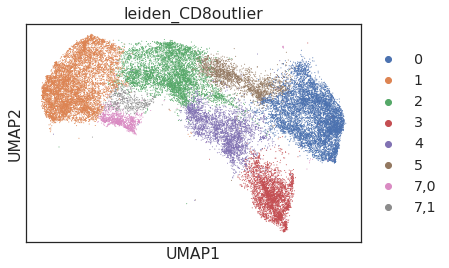

In [161]:
# Plot CD8 outlier annotation
sc.pl.umap(
    adata_pos_sub, 
    color= ["leiden_CD8outlier"], 
)

In [162]:
# Filter the CD8 early outlier cells
adata_pos_sub = adata_pos_sub[adata_pos_sub.obs["leiden_CD8outlier"] != "7,0", :].copy()

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [163]:
genotype_new = adata_pos_sub.obs["genotype"]
annotation_labels_new = adata_pos_sub.obs["annotation_labels"]

adata_pos_sub.obs["Genotype"] = genotype_new
adata_pos_sub.obs["Annotation_labels"] = annotation_labels_new

In [164]:
genotype_new

AAACCCAAGGACATCG-1-0     B6
AAACCCACATTCTCCG-1-0     B6
AAACGCTGTCAACACT-1-0     B6
AAACGCTTCCATGCAA-1-0     B6
AAAGGATGTTTCGTGA-1-0     B6
                       ... 
TTTCGATCACTTCTCG-8-1    OT2
TTTGACTAGCACTCGC-8-1    OT2
TTTGATCTCACCTACC-8-1    OT2
TTTGGTTTCGACCATA-8-1    OT2
TTTGTTGAGTTTGAGA-8-1    OT2
Name: genotype, Length: 29408, dtype: category
Categories (7, object): ['AND', 'B2M-KO', 'B6', 'F5', 'MHC2-KO', 'OT1', 'OT2']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

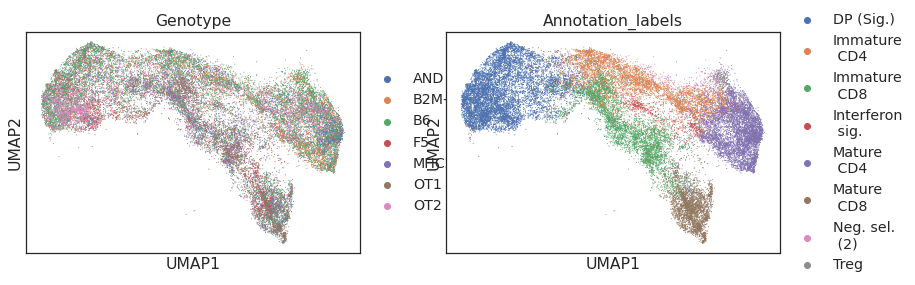

In [165]:
sc.pl.umap(
    adata_pos_sub, 
    color= ["Genotype", "Annotation_labels"]
)

## Plot positive selection subset by genotype

In [42]:
# Load metadata
selected_subset= pd.read_csv("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Slingshot_thymus/pseudotime_slingshot_2020913.csv")
selected_subset

curve1    curve2  difference  mean_pseudotime      UMAP1     UMAP2  \
0       8.730669       NaN         NaN         8.730669   6.462447  5.606827   
1      15.032939       NaN         NaN        15.032939  11.693608  2.355246   
2       5.076519  5.083563    0.007044         5.080041   2.775391  5.394828   
3       4.515456  4.519465    0.004008         4.517460   2.232010  5.238612   
4      12.608115       NaN         NaN        12.608115  10.659892  5.464911   
...          ...       ...         ...              ...        ...       ...   
29403  14.743658       NaN         NaN        14.743658  12.507417  3.905924   
29404   3.426831  3.429418    0.002587         3.428125   1.061256  5.715934   
29405   8.935091       NaN         NaN         8.935091   6.637168  5.373678   
29406  13.908873       NaN         NaN        13.908873  11.650050  4.229234   
29407   1.422436  1.423575    0.001139         1.423005  -0.140375  3.518340   

       weight_curve1  weight_curve2  Batch  UMIs_RNA  ...  \
0                1.0       0.000000      0      3944  ...   
1                1.0       0.000000      0      9445  ...   
2                1.0       1.000000      0      3260  ...   
3                1.0       1.000000      0      4305  ...   
4                1.0       0.000000      0      3296  ...   
...              ...            ...    ...       ...  ...   
29403            1.0       0.000000     18      2092  ...   
29404            1.0       1.000000     18      1558  ...   
29405            1.0       0.000000     18      2214  ...   
29406            1.0       0.000000     18      2984  ...   
29407            1.0       0.999707     18      1704  ...   

                        Sample  Genotype  Experiment   Location   Mouse  \
0                ZRS06_1_B6_r1        B6       ZRS06   Berkeley   B6_r1   
1                ZRS06_1_B6_r1        B6       ZRS06   Berkeley   B6_r1   
2                ZRS06_1_B6_r1        B6       ZRS06   Berkeley   B6_r1   
3                ZRS06_1_B6_r1        B6       ZRS06   Berkeley   B6_r1   
4                ZRS06_1_B6_r1        B6       ZRS06   Berkeley   B6_r1   
...                        ...       ...         ...        ...     ...   
29403  ZRS08_11_OT2_thy_r2_111       OT2       ZRS08  BioLegend  OT2_r2   
29404  ZRS08_11_OT2_thy_r2_111       OT2       ZRS08  BioLegend  OT2_r2   
29405  ZRS08_11_OT2_thy_r2_111       OT2       ZRS08  BioLegend  OT2_r2   
29406  ZRS08_11_OT2_thy_r2_111       OT2       ZRS08  BioLegend  OT2_r2   
29407  ZRS08_11_OT2_thy_r2_111       OT2       ZRS08  BioLegend  OT2_r2   

       slingshot_clusters  Lineage_by_genotype Lineage_by_genotypeSlingshot  \
0                       5                  NaN                          NaN   
1                       0                  NaN                          NaN   
2                       2                  NaN                          NaN   
3                       2                  NaN                          NaN   
4                       0                  NaN                          NaN   
...                   ...                  ...                          ...   
29403                   0                  CD4                          CD4   
29404                   1                  CD4                          CD4   
29405                   5                  CD4                          CD4   
29406                   0                  CD4                          CD4   
29407                   1                  CD4                          CD4   

      LinWeight_CD4 LinWeight_CD8  
0               NaN           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN  
...             ...           ...  
29403           1.0           0.0  
29404           1.0           0.0  
29405           1.0           0.0  
29406           1.0           0.0  
29407           1.0           0.0  

[29408 rows x 28 columns]

In [43]:
adata_subset = adata_full.copy()[selected_subset["Barcode"]]

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [44]:
subset_umap = selected_subset[["UMAP1", "UMAP2"]]
subset_umap.index = selected_subset["Barcode"]
subset_umap

UMAP1     UMAP2
Barcode                                  
AAACCCAAGGACATCG-1-0   6.462447  5.606827
AAACCCACATTCTCCG-1-0  11.693608  2.355246
AAACGCTGTCAACACT-1-0   2.775391  5.394828
AAACGCTTCCATGCAA-1-0   2.232010  5.238612
AAAGGATGTTTCGTGA-1-0  10.659892  5.464911
...                         ...       ...
TTTCGATCACTTCTCG-8-1  12.507417  3.905924
TTTGACTAGCACTCGC-8-1   1.061256  5.715934
TTTGATCTCACCTACC-8-1   6.637168  5.373678
TTTGGTTTCGACCATA-8-1  11.650050  4.229234
TTTGTTGAGTTTGAGA-8-1  -0.140375  3.518340

[29408 rows x 2 columns]

In [45]:
adata_subset.obsm["X_umap"] = subset_umap

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'annotations_clean' as categorical


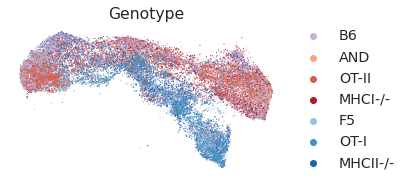

In [46]:
# Plot all genotypes
fig, ax = plt.subplots(figsize = (5, 2.75))

sc.pl.umap(
    adata_subset, 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    frameon = False,
    title = "Genotype",
    s = 5,
    palette = genotype_palette
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_subset_genotype.pdf", 
           dpi=DPI, bbox_inches='tight')

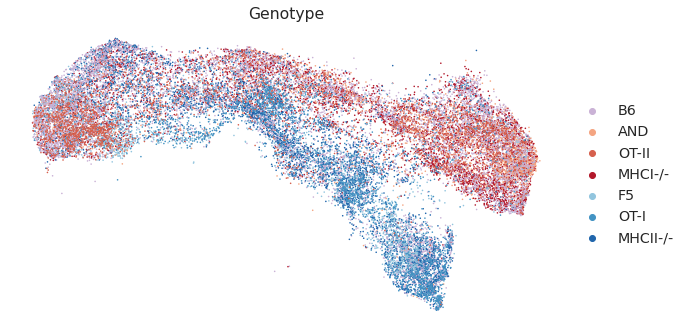

In [47]:
# Plot all genotypes to view
fig, ax = plt.subplots(figsize = (10, 5.5)) 

sc.pl.umap(
    adata_subset, 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    frameon = False,
    title = "Genotype",
    s = 10,
    palette = genotype_palette
)

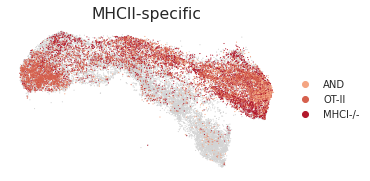

In [51]:
# PLot CD4 lineage (MHCII-specific)
fig, ax = plt.subplots(figsize=(5, 2.75))

sc.pl.umap(
    adata_subset, 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    groups = ["AND", "OT-II", "MHCI-/-"],
    frameon = False,
    legend_fontsize= "medium",
    title = "MHCII-specific",
    s = 5,
    palette = genotype_palette
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_subset_CD4lineage.pdf", 
           dpi=DPI, bbox_inches='tight')

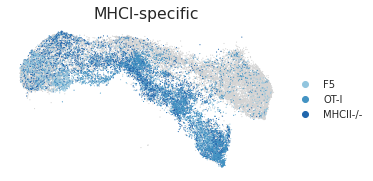

In [52]:
# Plot CD8 lineage (MHCI-specific)
fig, ax = plt.subplots(figsize = (5, 2.75)) 

sc.pl.umap(
    adata_subset, 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    groups = ["F5", "OT-I", "MHCII-/-"],
    frameon = False,
    legend_fontsize="medium",
    title = "MHCI-specific",
    s = 5,
    palette = genotype_palette
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_subset_CD8lineage.pdf", 
           dpi=DPI, bbox_inches='tight')

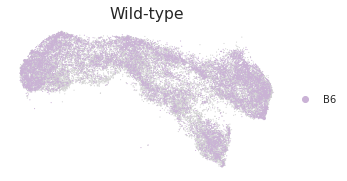

In [53]:
# Plot WT cells
fig, ax = plt.subplots(figsize = (5, 2.75)) 

sc.pl.umap(
    adata_subset, 
    color=["Genotype"],
    ncols=1,
    ax = ax,
    groups = ["B6"],
    frameon = False,
    legend_fontsize="medium",
    title = "Wild-type",
    s = 5,
    palette = genotype_palette
)

fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/annotate_subset_WTlineage.pdf", 
           dpi=DPI, bbox_inches='tight')

## Save results

In [378]:
# Save anndata object
adata_pos_sub.write("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/adata_positiveselection_filt.h5ad")

In [382]:
adata_pos_sub.shape

(29408, 5108)

In [379]:
# Save .obs (cluster labels)
obs_df = pd.DataFrame(adata_pos_sub.obs)
save_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/"

In [380]:
obs_df

batch_indices  percent_mito  n_counts  n_protein_counts  \
AAACCCAAGGACATCG-1-0             0      0.065669    3944.0            8718.0   
AAACCCACATTCTCCG-1-0             0      0.048491    9445.0            6642.0   
AAACGCTGTCAACACT-1-0             0      0.044785    3260.0            5785.0   
AAACGCTTCCATGCAA-1-0             0      0.055749    4305.0            6994.0   
AAAGGATGTTTCGTGA-1-0             0      0.049454    3296.0            6077.0   
...                            ...           ...       ...               ...   
TTTCGATCACTTCTCG-8-1            18      0.041109    2092.0            4904.0   
TTTGACTAGCACTCGC-8-1            18      0.067394    1558.0            4789.0   
TTTGATCTCACCTACC-8-1            18      0.055104    2214.0            5139.0   
TTTGGTTTCGACCATA-8-1            18      0.049933    2984.0            5953.0   
TTTGTTGAGTTTGAGA-8-1            18      0.038732    1704.0            3527.0   

                      n_proteins batch  n_genes leiden_totalVI_res1.4  \
AAACCCAAGGACATCG-1-0         104     0     1735                     3   
AAACCCACATTCTCCG-1-0         106     0     2595                    20   
AAACGCTGTCAACACT-1-0         106     0     1698                    15   
AAACGCTTCCATGCAA-1-0         104     0     1984                    15   
AAAGGATGTTTCGTGA-1-0         100     0     1555                    11   
...                          ...   ...      ...                   ...   
TTTCGATCACTTCTCG-8-1          91     1      830                     1   
TTTGACTAGCACTCGC-8-1          93     1      850                    15   
TTTGATCTCACCTACC-8-1          86     1      890                     3   
TTTGGTTTCGACCATA-8-1          92     1     1046                     1   
TTTGTTGAGTTTGAGA-8-1          91     1      798                     4   

                     leiden_totalVI_res1.0 leiden_totalVI_res0.6  ...  \
AAACCCAAGGACATCG-1-0                     7                     5  ...   
AAACCCACATTCTCCG-1-0                     2                     0  ...   
AAACGCTGTCAACACT-1-0                     3                     2  ...   
AAACGCTTCCATGCAA-1-0                     5                     2  ...   
AAAGGATGTTTCGTGA-1-0                     4                     0  ...   
...                                    ...                   ...  ...   
TTTCGATCACTTCTCG-8-1                     2                     0  ...   
TTTGACTAGCACTCGC-8-1                     5                     1  ...   
TTTGATCTCACCTACC-8-1                     7                     5  ...   
TTTGGTTTCGACCATA-8-1                     2                     0  ...   
TTTGTTGAGTTTGAGA-8-1                     0                     1  ...   

                      ADT_anti-P2RY12_A0415_fore_prob  ADT_anti-P2RY12_A0415  \
AAACCCAAGGACATCG-1-0                         0.499923               4.266257   
AAACCCACATTCTCCG-1-0                         0.499995               4.138050   
AAACGCTGTCAACACT-1-0                         0.499718               3.096521   
AAACGCTTCCATGCAA-1-0                         0.499866               3.504874   
AAAGGATGTTTCGTGA-1-0                         0.497870               3.173329   
...                                               ...                    ...   
TTTCGATCACTTCTCG-8-1                         0.311667               3.549670   
TTTGACTAGCACTCGC-8-1                         0.352570               3.321783   
TTTGATCTCACCTACC-8-1                         0.341101               3.253196   
TTTGGTTTCGACCATA-8-1                         0.350426               4.347657   
TTTGTTGAGTTTGAGA-8-1                         0.402866               3.387920   

                      ADT_integrinb7_A0214_fore_prob  ADT_integrinb7_A0214  \
AAACCCAAGGACATCG-1-0                        0.276069              0.212416   
AAACCCACATTCTCCG-1-0                        0.499437             35.780632   
AAACGCTGTCAACACT-1-0                        0.269245              0.000000   
AAACGCTTCCATGCAA-1-0             

In [ ]:
obs_df.to_csv(save_path + "adata_positiveselection_filt_obs.csv.gz", index = True)

## DE and cell type markers

* Load model for full data
* Run a one vs all DE test across cell types (exclude doublets and dying cells)
* Plot marker features for each cell type

### DE by cell type

In [98]:
# Set save path (where data is saved)
save_path = '/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable/'

In [99]:
# Load data as anndata objects
# Data was pre-filtered in Filtering_thymus111.ipynb

dataset_Berkeley = anndata.read(save_path + "Berkeley_111.h5ad")
dataset_BioLegend = anndata.read(save_path + "BioLegend_111.h5ad")

In [100]:
# Prepare data for totalVI

# Filter unwanted proteins (HTO)
keep_pro_111 = np.array([not p.startswith("HTO") for p in dataset_Berkeley.uns["protein_names"]])

In [101]:
# Filter out hashtags and isotype controls

dataset_Berkeley.obsm["protein_expression"] = dataset_Berkeley.obsm["protein_expression"][:, keep_pro_111]
dataset_Berkeley.uns["protein_names"] = dataset_Berkeley.uns["protein_names"][keep_pro_111]
dataset_BioLegend.obsm["protein_expression"] = dataset_BioLegend.obsm["protein_expression"][:, keep_pro_111]
dataset_BioLegend.uns["protein_names"] = dataset_BioLegend.uns["protein_names"][keep_pro_111]

In [102]:
# Find highly variable genes (plus genes encoding proteins and other genes of interest) and use for totalVI

hvg_Berkeley = dataset_Berkeley.var["hvg_plus"]
hvg_BioLegend = dataset_BioLegend.var["hvg_plus"]

dataset_BioLegend.var["hvg_plus"].sum()

5125

In [103]:
# Make totalVI dataset

# Berkeley data
dataset_totalVI_Berkeley = AnnDatasetFromAnnData(ad = dataset_Berkeley[:, hvg_Berkeley],
                                                cell_measurements_col_mappings = {"protein_expression":"protein_names"})
dataset_totalVI_Berkeley

[2023-06-11 14:52:31,339] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-06-11 14:52:31,345] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-06-11 14:52:34,498] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-06-11 14:52:34,779] INFO - scvi.dataset.dataset | Downsampled from 36058 to 36058 cells


GeneExpressionDataset object with n_cells x nb_genes = 36058 x 5125
    gene_attribute_names: 'gene_ids', 'ofinterest', 'hvg_encode', 'highly_variable', 'hvg_plus', 'n_cells', 'gene_names', 'feature_types', 'encode'
    cell_attribute_names: 'n_protein_counts', 'local_vars', 'local_means', 'labels', 'n_genes', 'batch_indices', 'n_counts', 'n_proteins', 'protein_expression', 'percent_mito'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [104]:
# BioLegend data

dataset_totalVI_BioLegend = AnnDatasetFromAnnData(ad = dataset_BioLegend[:, hvg_BioLegend],
                                                cell_measurements_col_mappings = {"protein_expression":"protein_names"})
dataset_totalVI_BioLegend

[2023-06-11 14:52:39,677] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-06-11 14:52:39,683] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-06-11 14:52:42,646] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-06-11 14:52:42,919] INFO - scvi.dataset.dataset | Downsampled from 35984 to 35984 cells


GeneExpressionDataset object with n_cells x nb_genes = 35984 x 5125
    gene_attribute_names: 'gene_ids', 'ofinterest', 'hvg_encode', 'highly_variable', 'hvg_plus', 'n_cells', 'gene_names', 'feature_types', 'encode'
    cell_attribute_names: 'n_protein_counts', 'local_vars', 'local_means', 'labels', 'n_genes', 'batch_indices', 'n_counts', 'n_proteins', 'protein_expression', 'percent_mito'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [105]:
# Concatenate two datasets into one

dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [copy.deepcopy(dataset_totalVI_Berkeley), copy.deepcopy(dataset_totalVI_BioLegend)],
)

[2023-06-11 14:52:46,193] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2023-06-11 14:52:46,194] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2023-06-11 14:52:46,205] INFO - scvi.dataset.dataset | Keeping 5125 genes
[2023-06-11 14:52:49,783] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-06-11 14:52:50,242] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-06-11 14:52:50,245] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-06-11 14:52:53,772] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-06-11 14:52:54,473] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-06-11 14:52:54,477] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-06-11 14:52:57,086] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-06-11 14:52:57,091] I

In [106]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 72042 x 5125
    gene_attribute_names: 'gene_ids', 'ofinterest', 'hvg_encode', 'highly_variable', 'hvg_plus', 'n_cells', 'gene_names', 'feature_types', 'encode'
    cell_attribute_names: 'n_protein_counts', 'local_vars', 'local_means', 'labels', 'n_genes', 'batch_indices', 'n_counts', 'n_proteins', 'protein_expression', 'percent_mito'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [107]:
# How many batches after merging? 11 from Berkeley, 8 from BioLegend (they are retained)
dataset.n_batches

19

In [108]:
# Prepare totalVI model

totalvae = TOTALVI(dataset.nb_genes, 
                   len(dataset.protein_names),
                   n_latent = 20, 
                   n_batch=dataset.n_batches,
                  )

use_cuda = True
lr = 4e-3
n_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [109]:
# Load a saved model
model_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable/"
totalvae.load_state_dict(torch.load(model_path + "vae_54kWU.pt"))
totalvae.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=5255, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [110]:
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.95,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
    n_iter_kl_warmup=54000,    # default is .75* n cells, (increasing warmup will counteract the tendency to mix caused by injecting the batch at each layer)
    n_epochs_kl_warmup=None,
)


In [111]:
# Generate posterior on all cells from totalVI model

full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [112]:
cell_labels = adata_full.obs["annotations_clean"]
len(np.unique(cell_labels))

21

In [65]:
# Convert cell types into integers to use in DE test
cell_type_df = pd.DataFrame({"cell_types": np.unique(cell_labels),
             "cell_type_int": range(len(np.unique(cell_labels)))})

In [66]:
cell_type_nums = [cell_type_df[cell_type_df["cell_types"] == cell_label]["cell_type_int"].values[0] for cell_label in cell_labels]

In [114]:
# Test DE on all cell types excluding doublets and dying cells
include_cells_de = [c not in ["Doublet", "Dying"] for c in cell_labels]

In [115]:
np.sum(include_cells_de)

69813

In [116]:
# one-vs-all DE test on cell clusters

res_onevall, clust_onevall = full_posterior.one_vs_all_degenes(
    subset = include_cells_de,
    cell_labels = np.array(cell_type_nums),
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [117]:
clust_onevall

[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [118]:
np.array(cell_type_df["cell_types"])[clust_onevall]

array(['B', 'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)',
       'Erythrocyte', 'GD T', 'Immature CD4', 'Immature CD8',
       'Interferon sig.', 'Mature CD4', 'Mature CD8', 'Mature cycling',
       'Myeloid', 'NKT', 'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg'],
      dtype=object)

In [119]:
# Concatenate DE results across clusters to make filtering and viewing easier
all_de = pd.concat(res_onevall)

In [121]:
# Save DE results
all_de.to_csv("DE_onevall_thymus.csv")

In [60]:
# Add cell type labels to clusters
all_de = pd.read_csv("DE_onevall_thymus.csv", index_col = 0)

In [122]:
all_de

proba_de  proba_not_de  bayes_factor    scale1  \
Igha                  1.000000      0.000000     18.420681  0.000219   
AI607873              1.000000      0.000000     18.420681  0.000018   
Ebf1                  1.000000      0.000000     18.420681  0.001465   
Il1b                  1.000000      0.000000     18.420681  0.000005   
Bcl2a1a               1.000000      0.000000     18.420681  0.000042   
...                        ...           ...           ...       ...   
ADT_CD45R-B220_A0103  0.207124      0.792876     -1.342347  0.763219   
ADT_CD20_A0192        0.196518      0.803482     -1.408201  2.451108   
ADT_Ly-6C_A0013       0.044827      0.955173     -3.059084  1.537049   
ADT_CD23_A0108        0.031819      0.968181     -3.415352  0.719152   
ADT_CD19_A0093        0.021613      0.978387     -3.812611  0.810841   

                            scale2   lfc_mean  lfc_median   lfc_std   lfc_min  \
Igha                  4.385415e-07  10.251663   10.356222  2.135738 -1.361961   
AI607873              1.998884e-06   6.940922    7.059233  2.040341 -5.940070   
Ebf1                  1.450313e-06   9.562915    9.686481  2.199537  0.467527   
Il1b                  1.663497e-06   6.298254    6.359325  1.975492 -8.705153   
Bcl2a1a               3.112381e-06   7.782489    7.916092  2.110567 -5.714213   
...                            ...        ...         ...       ...       ...   
ADT_CD45R-B220_A0103  9.726158e-01  -0.231783    0.000000  1.085573 -8.556929   
ADT_CD20_A0192        1.805298e+00   0.189582    0.000000  1.628943 -6.824404   
ADT_Ly-6C_A0013       1.397908e+00   0.015251    0.000000  1.244242 -9.363420   
ADT_CD23_A0108        6.406899e-01   0.027445    0.000000  0.683663 -8.115370   
ADT_CD19_A0093        7.253122e-01   0.024275    0.000000  0.727912 -9.056508   

                        lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
Igha                  17.121695   1.584906   0.000717               0.216981   
AI607873              13.417134   0.009434   0.004103               0.009434   
Ebf1                  17.327835   3.773585   0.002826               0.820755   
Il1b                  13.185053   0.000000   0.003242               0.000000   
Bcl2a1a               15.088317   0.113208   0.004820               0.066038   
...                         ...        ...        ...                    ...   
ADT_CD45R-B220_A0103   7.441980   1.041200   1.667207               0.549339   
ADT_CD20_A0192         6.902007   4.403866   4.994517               0.875890   
ADT_Ly-6C_A0013        8.529648   2.612920   3.426931               0.768057   
ADT_CD23_A0108         7.587401   0.988301   1.151827               0.452187   
ADT_CD19_A0093         8.056359   1.487792   1.819609               0.616480   

                      non_zeros_proportion2  raw_normalized_mean1  \
Igha                               0.000344              2.297010   
AI607873                           0.002008              0.006706   
Ebf1                               0.002295             10.698483   
Il1b                               0.000732              0.000000   
Bcl2a1a                            0.002195              0.209186   
...                                     ...                   ...   
ADT_CD45R-B220_A0103               0.672778                   NaN   
ADT_CD20_A0192                     0.922222                   NaN   
ADT_Ly-6C_A0013                    0.811104                   NaN   
ADT_CD23_A0108                     0.548057                   NaN   
ADT_CD19_A0093                     0.681357                   NaN   

                      raw_normalized_mean2  clusters  
Igha                              0.002177         0  
AI607873                          0.008158         0  
Ebf1                              0.008637         0  
Il1b                              0.007393         0  
Bcl2a1a                           0.010783         0  
...                                    ...       ...  
ADT_CD45R

In [67]:
cell_type_df

cell_types  cell_type_int
0                 B              0
1                DN              1
2            DP (P)              2
3           DP (Q1)              3
4           DP (Q2)              4
5         DP (Sig.)              5
6           Doublet              6
7             Dying              7
8       Erythrocyte              8
9              GD T              9
10     Immature CD4             10
11     Immature CD8             11
12  Interferon sig.             12
13       Mature CD4             13
14       Mature CD8             14
15   Mature cycling             15
16          Myeloid             16
17              NKT             17
18    Neg. sel. (1)             18
19    Neg. sel. (2)             19
20             Treg             20

In [123]:
cell_type_DE_labels = [cell_type_df[cell_type_df["cell_type_int"] == cluster]["cell_types"].values[0] for cluster in all_de.loc[:, "clusters"].values]

In [124]:
# Add cell type labels to the DE dataset
all_de["clusters"] = cell_type_DE_labels

In [125]:
all_de

proba_de  proba_not_de  bayes_factor    scale1  \
Igha                  1.000000      0.000000     18.420681  0.000219   
AI607873              1.000000      0.000000     18.420681  0.000018   
Ebf1                  1.000000      0.000000     18.420681  0.001465   
Il1b                  1.000000      0.000000     18.420681  0.000005   
Bcl2a1a               1.000000      0.000000     18.420681  0.000042   
...                        ...           ...           ...       ...   
ADT_CD45R-B220_A0103  0.207124      0.792876     -1.342347  0.763219   
ADT_CD20_A0192        0.196518      0.803482     -1.408201  2.451108   
ADT_Ly-6C_A0013       0.044827      0.955173     -3.059084  1.537049   
ADT_CD23_A0108        0.031819      0.968181     -3.415352  0.719152   
ADT_CD19_A0093        0.021613      0.978387     -3.812611  0.810841   

                            scale2   lfc_mean  lfc_median   lfc_std   lfc_min  \
Igha                  4.385415e-07  10.251663   10.356222  2.135738 -1.361961   
AI607873              1.998884e-06   6.940922    7.059233  2.040341 -5.940070   
Ebf1                  1.450313e-06   9.562915    9.686481  2.199537  0.467527   
Il1b                  1.663497e-06   6.298254    6.359325  1.975492 -8.705153   
Bcl2a1a               3.112381e-06   7.782489    7.916092  2.110567 -5.714213   
...                            ...        ...         ...       ...       ...   
ADT_CD45R-B220_A0103  9.726158e-01  -0.231783    0.000000  1.085573 -8.556929   
ADT_CD20_A0192        1.805298e+00   0.189582    0.000000  1.628943 -6.824404   
ADT_Ly-6C_A0013       1.397908e+00   0.015251    0.000000  1.244242 -9.363420   
ADT_CD23_A0108        6.406899e-01   0.027445    0.000000  0.683663 -8.115370   
ADT_CD19_A0093        7.253122e-01   0.024275    0.000000  0.727912 -9.056508   

                        lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
Igha                  17.121695   1.584906   0.000717               0.216981   
AI607873              13.417134   0.009434   0.004103               0.009434   
Ebf1                  17.327835   3.773585   0.002826               0.820755   
Il1b                  13.185053   0.000000   0.003242               0.000000   
Bcl2a1a               15.088317   0.113208   0.004820               0.066038   
...                         ...        ...        ...                    ...   
ADT_CD45R-B220_A0103   7.441980   1.041200   1.667207               0.549339   
ADT_CD20_A0192         6.902007   4.403866   4.994517               0.875890   
ADT_Ly-6C_A0013        8.529648   2.612920   3.426931               0.768057   
ADT_CD23_A0108         7.587401   0.988301   1.151827               0.452187   
ADT_CD19_A0093         8.056359   1.487792   1.819609               0.616480   

                      non_zeros_proportion2  raw_normalized_mean1  \
Igha                               0.000344              2.297010   
AI607873                           0.002008              0.006706   
Ebf1                               0.002295             10.698483   
Il1b                               0.000732              0.000000   
Bcl2a1a                            0.002195              0.209186   
...                                     ...                   ...   
ADT_CD45R-B220_A0103               0.672778                   NaN   
ADT_CD20_A0192                     0.922222                   NaN   
ADT_Ly-6C_A0013                    0.811104                   NaN   
ADT_CD23_A0108                     0.548057                   NaN   
ADT_CD19_A0093                     0.681357                   NaN   

                      raw_normalized_mean2 clusters  
Igha                              0.002177        B  
AI607873                          0.008158        B  
Ebf1                              0.008637        B  
Il1b                              0.007393        B  
Bcl2a1a                           0.010783        B  
...                                    ...      ...  
ADT_CD45R-B220_A

In [126]:
# Save a new DE csv with cell type labels
all_de.to_csv("DE_onevall_thymus_labeled_rev1.csv")

### Plot RNA cell type markers

In [127]:
# Collect top genes for each cell cluster
# Save markers as a dictionary for them to be sorted in scanpy

thymus_categories = np.array(cell_type_df["cell_types"])[clust_onevall]

thymus_marker_genes = {}
all_marker_genes = []
for cluster in range(len(res_onevall)):
    cluster_markers = []
    RNA_de_filt = res_onevall[cluster].loc[res_onevall[cluster]['non_zeros_proportion1'] > 0.1] 
    RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_mean'] > 0] 
    RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['lfc_median'] > 0.2] 

    RNA_de_filt = RNA_de_filt.sort_values(by = "lfc_median", ascending = False) 
    RNA_de_filt = RNA_de_filt.loc[RNA_de_filt['bayes_factor'] > 2] 
    RNA_de_filt = RNA_de_filt.iloc[~RNA_de_filt.index.str.contains("ADT_")]                            
    RNA = RNA_de_filt.index[0:4].values 
    
    # Make sure markers are unique
    for i in range(len(RNA)):
        if RNA[i] not in all_marker_genes:
            cluster_markers.append(RNA[i])
            all_marker_genes.append(RNA[i])

    thymus_marker_genes[thymus_categories[cluster]] = cluster_markers

In [128]:
thymus_marker_genes

{'B': ['Iglc3', 'Iglc2', 'Gm43291', 'Ms4a1'],
 'DN': ['Tcrg-C2', 'Hes1', 'Mpzl2', '1500009L16Rik'],
 'DP (P)': ['Hist1h2af', 'Hist1h3b', 'Esco2', 'Mki67'],
 'DP (Q1)': ['Insl5', 'Slc7a11', 'P2rx1', 'Rag1'],
 'DP (Q2)': ['BB031773', 'Tctex1d1'],
 'DP (Sig.)': ['Rapsn', 'Ccr4', 'Egr2', 'Itm2a'],
 'Erythrocyte': ['Snca', 'Alas2', 'Gypa', 'Hba-a2'],
 'GD T': ['Cpa3', 'Gm16602', 'Tcrg-C4', '5830411N06Rik'],
 'Immature CD4': ['Cd40lg', 'Zbtb7b', 'Chl1', 'Gm26771'],
 'Immature CD8': ['Acvrl1', 'Tesc', 'Nkg7'],
 'Interferon sig.': ['Ifit1', 'Iigp1', 'Rsad2', 'Oasl2'],
 'Mature CD4': ['S1pr1', 'Fam101b', 'Dapl1', 'Slfn1'],
 'Mature CD8': ['Gm43698'],
 'Mature cycling': ['BC030867'],
 'Myeloid': ['Ctsh', 'Spi1', 'Tyrobp', 'Mpeg1'],
 'NKT': ['S100a4', 'Zbtb16', 'Klrb1a', 'Klra1'],
 'Neg. sel. (1)': ['Nr4a3', 'Pdcd1lg2', 'Tnfrsf9', '2610204G07Rik'],
 'Neg. sel. (2)': ['Arhgap20', 'Tnfrsf4'],
 'Treg': ['Foxp3', 'Slc22a2', 'Lad1']}

In [129]:
# Order cell types for plotting
thymus_categories_ordered = pd.Series(pd.Categorical(['Erythrocyte', 'B', 'Myeloid', 
                             'GD T', 
                             'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)',
                           
                              'Interferon sig.', 'Immature CD4', 'Immature CD8', 'Mature CD4', 'Mature CD8', 'Mature cycling', 
                             'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg', 'NKT'], 
                                                     categories = ['Erythrocyte', 'B', 'Myeloid', 
                             'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)',
                           
                              'Interferon sig.', 'Immature CD4', 'Immature CD8', 'Mature CD4', 'Mature CD8', 'Mature cycling', 
                             'GD T', 'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg', 'NKT'],
                                                     ordered = True))

In [130]:
# Some top DE genes are DE for multiple clusters
# For each unique feature in all_markers, find which cluster it belongs to (highest LFC) and add it to the dictionary

thymus_marker_genes_clustered = {}

for feature in all_marker_genes:
    LFC_for_feature = all_de.loc[feature].reset_index() # LFC for this feature in all clusters
    cluster_membership_num = LFC_for_feature["lfc_median"].idxmax() # Cluster number where feature has highest LFC

    cluster_membership = thymus_categories[cluster_membership_num] # name
    if cluster_membership in thymus_marker_genes_clustered.keys():
        thymus_marker_genes_clustered[cluster_membership].append(feature)
    else:
        thymus_marker_genes_clustered[cluster_membership] = [feature]

# Remake dictionary to match the order of the cell types
thymus_marker_genes = {}
for cell_type in thymus_categories_ordered:
    if cell_type in thymus_marker_genes_clustered.keys():
        thymus_marker_genes[cell_type] = thymus_marker_genes_clustered[cell_type]
    else:
        thymus_marker_genes[cell_type] = []

print(thymus_marker_genes)

{'Erythrocyte': ['Snca', 'Alas2', 'Gypa', 'Hba-a2', 'Rsad2', 'Oasl2'], 'B': ['Iglc3', 'Iglc2', 'Gm43291', 'Ms4a1', 'Ctsh', 'Spi1'], 'Myeloid': ['Tyrobp', 'Mpeg1'], 'GD T': ['Tcrg-C2', 'Cpa3', 'Gm16602', 'Tcrg-C4', '5830411N06Rik'], 'DN': ['Hes1', 'Mpzl2', '1500009L16Rik'], 'DP (P)': ['Hist1h2af', 'Hist1h3b', 'Esco2', 'Mki67', 'BC030867'], 'DP (Q1)': ['Insl5'], 'DP (Q2)': ['Slc7a11', 'P2rx1', 'Rag1', 'BB031773', 'Tctex1d1'], 'DP (Sig.)': ['Rapsn', 'Ccr4'], 'Interferon sig.': ['Ifit1', 'Iigp1'], 'Immature CD4': ['Itm2a', 'Cd40lg', 'Zbtb7b', 'Chl1', 'Acvrl1'], 'Immature CD8': ['Tesc'], 'Mature CD4': ['Gm26771', 'S1pr1', 'Slfn1'], 'Mature CD8': ['Nkg7', 'Fam101b', 'Dapl1', 'Gm43698'], 'Mature cycling': [], 'Neg. sel. (1)': ['Egr2', 'Nr4a3', 'Pdcd1lg2', '2610204G07Rik'], 'Neg. sel. (2)': ['Tnfrsf4'], 'Treg': ['Tnfrsf9', 'Arhgap20', 'Foxp3', 'Slc22a2', 'Lad1'], 'NKT': ['S100a4', 'Zbtb16', 'Klrb1a', 'Klra1']}


In [131]:
thymus_markers_T = thymus_marker_genes.copy()

In [132]:
# Choose cells for display in matrix plot (only T cells)
include_cells_plot = [c not in ["Doublet", "Dying"] for c in cell_labels]

In [78]:
# Make RNA anndata object with denoised values
rna_adata_full = anndata.AnnData(adata_full.X).copy()
rna_adata_full.var.index = adata_full.uns["totalVI_genes"]
rna_adata_full.raw = rna_adata_full
rna_adata_full.X = adata_full.obsm["denoised_genes"]
rna_adata_full.obsm["X_umap"] = adata_full.obsm["X_umap"]
rna_adata_full.obs["cell_type"] = pd.Series(adata_full.obs["annotations_clean"].values, dtype = "category").values
rna_adata_full = rna_adata_full[include_cells_plot]
rna_adata_full.shape

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(69813, 5125)

In [133]:
rna_adata_full.obs["cell_type"].cat.categories

Index(['Erythrocyte', 'B', 'Myeloid', 'GD T', 'DN', 'DP (P)', 'DP (Q1)',
       'DP (Q2)', 'DP (Sig.)', 'Interferon sig.', 'Immature CD4',
       'Immature CD8', 'Mature CD4', 'Mature CD8', 'Mature cycling',
       'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg', 'NKT'],
      dtype='object')

In [85]:
# Set order of cell types
rna_adata_full.obs["cell_type"].cat.reorder_categories(["Erythrocyte", "B", "Myeloid",
    'GD T', 'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)',
                              'Interferon sig.', 'Immature CD4', 'Immature CD8', 'Mature CD4', 'Mature CD8', 'Mature cycling', 
                             'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg', 'NKT'], inplace = True)

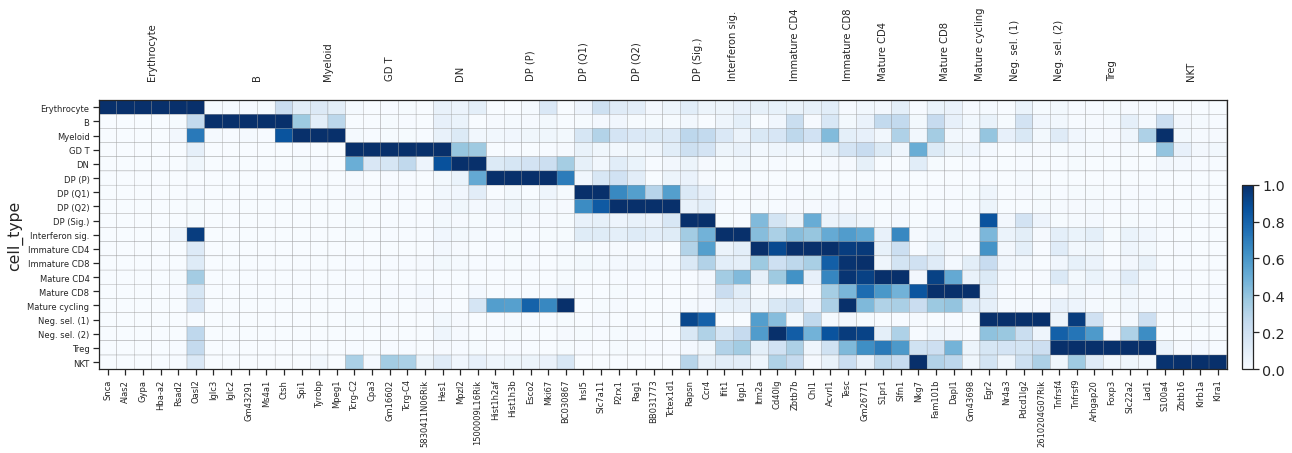

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[20.48, 0, 0.2])

In [135]:
# Plot top genes in a heatmap (matrixplot in scanpy)

sc.pl.matrixplot(
    rna_adata_full,
    thymus_markers_T,
    groupby="cell_type",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Blues",
    var_group_rotation = 90,
    save = "thymus_RNA_rev1.pdf"
)

### Plot protein cell type markers

In [136]:
# Collect top proteins for each cell cluster
# Save markers as a dictionary for them to be sorted in scanpy

thymus_categories = np.array(cell_type_df["cell_types"])[clust_onevall]

thymus_marker_proteins = {}
all_marker_proteins = []
for cluster in range(len(res_onevall)):
    cluster_markers = []
    
    protein_de_filt = res_onevall[cluster]
    protein_de_filt = protein_de_filt.loc[protein_de_filt['lfc_mean'] > 0] 
    protein_de_filt = protein_de_filt.loc[protein_de_filt['lfc_median'] > 0.2] 
    protein_de_filt = protein_de_filt.sort_values(by = "lfc_median", ascending = False) 
    protein_de_filt = protein_de_filt.loc[protein_de_filt['bayes_factor'] > 1] 
    protein_de_filt = protein_de_filt.iloc[protein_de_filt.index.str.contains("ADT_")]                            
    protein = protein_de_filt.index[0:4].values 
    
    # Make sure markers are unique
    for i in range(len(protein)):
        if protein[i] not in all_marker_proteins:
            cluster_markers.append(protein[i])
            all_marker_proteins.append(protein[i])

    thymus_marker_proteins[thymus_categories[cluster]] = [s.split("_")[1] for s in cluster_markers] 
thymus_marker_proteins    

{'B': ['CD38', 'Ly-6A-E(Sca-1)', 'CD55(DAF)', 'CD45R-B220'],
 'DN': ['CD304(Neuropilin-1)', 'CD71', 'CD49d', 'CD326(Ep-CAM)'],
 'DP (P)': ['CD29', 'Notch1'],
 'DP (Q1)': ['CD8b(Ly-3)', 'CD102', 'CD8a'],
 'DP (Q2)': ['CD150(SLAM)', 'CD4'],
 'DP (Sig.)': ['CD28', 'CD69', 'CD5'],
 'Erythrocyte': ['I-A-I-E', 'CD24'],
 'GD T': ['CD62L', 'CD279(PD-1)', 'CD48'],
 'Immature CD4': ['CD278(ICOS)', 'TCRbchain'],
 'Immature CD8': ['CD11a'],
 'Interferon sig.': [],
 'Mature CD4': ['integrinb7', 'CD127(IL-7Ra)'],
 'Mature CD8': ['CD103'],
 'Mature cycling': [],
 'Myeloid': ['CD86', 'CD54', 'CD11c'],
 'NKT': ['CD73'],
 'Neg. sel. (1)': ['CD274(B7-H1'],
 'Neg. sel. (2)': ['CD357(GITR)'],
 'Treg': ['CD200(OX2)']}

In [137]:
# Some top DE proteins are DE for multiple clusters
# For each unique feature in all_markers, find which cluster it belongs to (highest LFC) and add it to the dictionary

thymus_marker_proteins_clustered = {}

for feature in all_marker_proteins:
    LFC_for_feature = all_de.loc[feature].reset_index() # LFC for this feature in all clusters
    cluster_membership_num = LFC_for_feature["lfc_median"].idxmax() # Cluster number where feature has highest LFC

    cluster_membership = thymus_categories[cluster_membership_num] # name
    if cluster_membership in thymus_marker_proteins_clustered.keys():
        thymus_marker_proteins_clustered[cluster_membership].append(feature.split("_")[1])
    else:
        thymus_marker_proteins_clustered[cluster_membership] = [feature.split("_")[1]]

# Remake dictionary to match the order of the cell types
thymus_marker_proteins = {}
for cell_type in thymus_categories_ordered:
    if cell_type in thymus_marker_proteins_clustered.keys():
        thymus_marker_proteins[cell_type] = thymus_marker_proteins_clustered[cell_type]
    else:
        thymus_marker_proteins[cell_type] = []

thymus_marker_proteins

{'Erythrocyte': ['CD71'],
 'B': ['CD38',
  'Ly-6A-E(Sca-1)',
  'CD55(DAF)',
  'CD45R-B220',
  'I-A-I-E',
  'CD54',
  'CD274(B7-H1'],
 'Myeloid': ['CD86', 'CD11c'],
 'GD T': ['CD62L'],
 'DN': ['CD49d', 'CD326(Ep-CAM)', 'CD29', 'Notch1', 'CD102', 'CD24', 'CD48'],
 'DP (P)': ['CD304(Neuropilin-1)', 'CD8a'],
 'DP (Q1)': ['CD8b(Ly-3)'],
 'DP (Q2)': ['CD150(SLAM)'],
 'DP (Sig.)': [],
 'Interferon sig.': [],
 'Immature CD4': [],
 'Immature CD8': [],
 'Mature CD4': ['CD4', 'TCRbchain'],
 'Mature CD8': ['integrinb7', 'CD127(IL-7Ra)', 'CD103'],
 'Mature cycling': ['CD278(ICOS)'],
 'Neg. sel. (1)': ['CD28'],
 'Neg. sel. (2)': ['CD69', 'CD5', 'CD11a'],
 'Treg': ['CD357(GITR)', 'CD200(OX2)'],
 'NKT': ['CD279(PD-1)', 'CD73']}

In [138]:
thymus_markers_prot_T = thymus_marker_proteins.copy()

In [93]:
# Make protein anndata object with denoised values
protein_adata_full = anndata.AnnData(np.log1p(adata_full.obsm["protein_expression"]))
protein_adata_full.var.index = adata_full.uns["totalVI_proteins"]
protein_adata_full.raw = protein_adata_full
protein_adata_full.X = adata_full.obsm["denoised_proteins"]
protein_adata_full.obsm["X_umap"] = adata_full.obsm["X_umap"]
protein_adata_full.obs["cell_type"] = pd.Series(adata_full.obs["annotations_clean"].values, dtype = "category").values
protein_adata_full = protein_adata_full[include_cells_plot]
protein_adata_full.shape

(69813, 111)

In [139]:
# Set order of cell types
protein_adata_full.obs["cell_type"].cat.reorder_categories(["Erythrocyte", "B", "Myeloid",
    'GD T', 'DN', 'DP (P)', 'DP (Q1)', 'DP (Q2)', 'DP (Sig.)',
                              'Interferon sig.', 'Immature CD4', 'Immature CD8', 'Mature CD4', 'Mature CD8', 'Mature cycling', 
                             'Neg. sel. (1)', 'Neg. sel. (2)', 'Treg', 'NKT'], inplace = True)

In [145]:
# Abbreviate protein names for plotting
protein_adata_full.var.index = ([s.split("_")[1] for s in protein_adata_full.var.index.values])

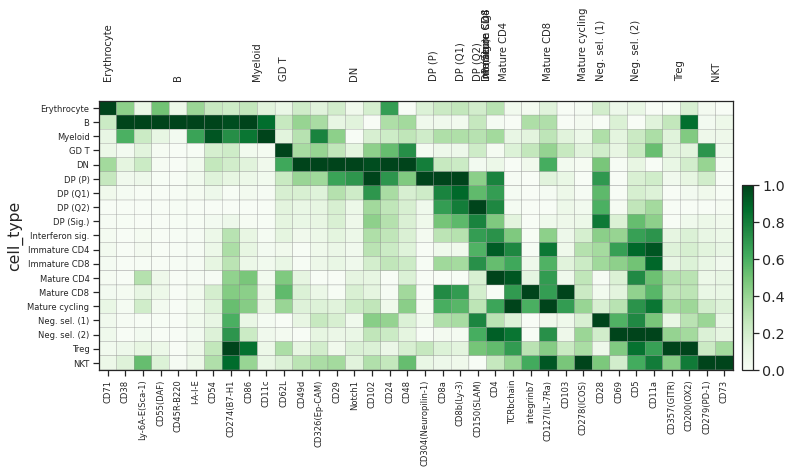

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[11.52, 0, 0.2])

In [142]:
sc.pl.matrixplot(
    protein_adata_full,
    thymus_markers_prot_T,
    groupby="cell_type",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Greens",
    var_group_rotation = 90,
    save = "thymus_protein_rev1.pdf"
)

## Plot manual marker list

In [88]:
# Manual RNA markers
manual_RNA_markers = {'Erythrocyte': ['Hbb-bs', 'Hbb-bt'], 
                      'B': ['Cd19', 'Ighd'], 
                      'Myeloid': ["Itgax", 'Anxa3', 'S100a8', 'C1qa'], 
                      'GD T': ['Tcrg-C1', 'Trdc'], 
                      'DN': ['Ptcra', 'Il2ra'], 
                      'DP (P)': ['Cd4', 'Cd8a', 'Top2a', 'Mki67'], 
                      'DP (Q1)': ['Rag1', 'Lgals1'], 
                      'DP (Q2)': ['Rag1', 'Cd52'], 
                      'DP (Sig.)': ['Cd69', 'Ccr4'], 
                      'Interferon sig.': ['Ifit1', "Isg15"],                   
                      'Immature CD4': ['Itm2a', 'Zbtb7b', 'Cd40lg'], 
                      'Immature CD8': ["Cd8a", "Runx3"], 
                      'Mature CD4': ['Cd4', 'Zbtb7b', 'S1pr1'],                       
                      'Mature CD8': ["Cd8a", 'Runx3', 'Nkg7', 'S1pr1'], 
                      'Mature cycling': ["Stmn1", "Top2a", "H2-K1"], 
                      'Neg. sel. (1)': ["Pdcd1", "Ikzf2", "Nr4a1", "Bcl2l11"], 
                      'Neg. sel. (2)': ["Cd4", "Ccr7", "Ikzf2", "Bcl2l11"], 
                      'Treg': ['Foxp3'], 
                      'NKT': ['Klrd1']
                                        }

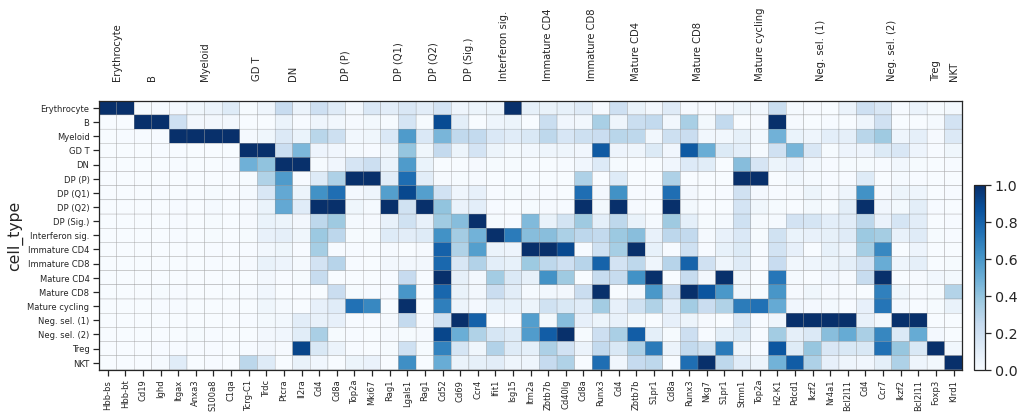

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[15.68, 0, 0.2])

In [91]:
# Plot manual RNA markers
sc.pl.matrixplot(
    rna_adata_full,
    manual_RNA_markers, 
    groupby="cell_type",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Blues",
    save = "thymus_RNA_manual_rev1.pdf"
)

In [96]:
# Manual protein markers
manual_protein_markers = {'Erythrocyte': ['CD71'], 
                      'B': ['CD19', 'CD20'], 
                      'Myeloid': ['F4-80', 'CD11c'], 
                      'GD T': ['TCRr-d'], 
                      'DN': ['CD25', "CD24"], 
                      'DP': ['CD4', 'CD8a', 'CD8b(Ly-3)'],   
                      'Immature CD4': ['CD4', 'CD127(IL-7Ra)'], 
                      'Immature CD8': ['CD8a', "CD127(IL-7Ra)"],   
                      'Mature CD4': ['CD62L', 'CD4'], 
                      'Mature CD8': ['CD62L', "CD8a"], 
                      'Neg. sel. (1)': ['CD69', 'CD5'], 
                      'Neg. sel. (2)': ['CD69', "CD5", "CD127(IL-7Ra)"], 
                      'Treg': ['CD357(GITR)'],
                      'NKT': ['NK-1.1']}

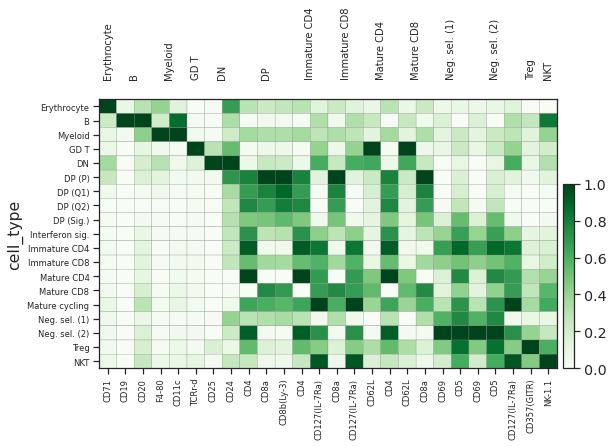

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[8.32, 0, 0.2])

In [97]:
# Plot manual protein markers
sc.pl.matrixplot(
    protein_adata_full,
    manual_protein_markers,
    groupby="cell_type",
    dendrogram=False,
    use_raw=False,
    standard_scale = "var",
    cmap = "Greens",
    var_group_rotation = 90,
    save = "thymus_protein_manual_rev1.pdf"
)

## Plot markers on UMAP

In [54]:
adata_pos_sub = adata_pos.copy()[selected_subset["Barcode"]]
adata_pos_sub.shape

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(29408, 5108)

In [55]:
# Make denoised RNA adata object
rna_adata = anndata.AnnData(adata_pos_sub.X)
rna_adata.var.index = adata_pos_sub.uns["totalVI_genes"]
rna_adata.raw = rna_adata
rna_adata.X = adata_pos_sub.obsm["denoised_genes"]
rna_adata.obsm["X_umap"] = adata_pos_sub.obsm["X_umap"]

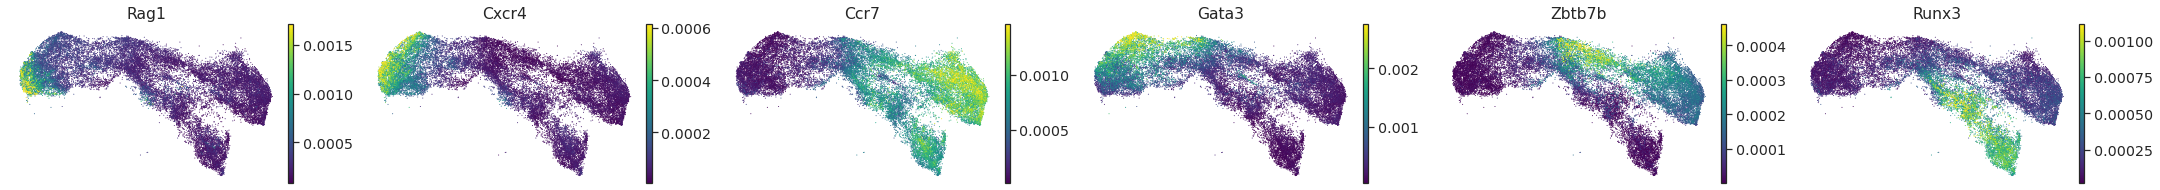

In [56]:
fig, ax_arr = plt.subplots(1,6, figsize = (5*6, 2.75))

for i, RNA in enumerate(["Rag1", 'Cxcr4', "Ccr7", 'Gata3', "Zbtb7b", "Runx3"]):
    sc.pl.umap(
        rna_adata, 
        use_raw = False,
        color=RNA, 
        ncols=1, 
        color_map = "viridis", 
        frameon = False,
        ax = ax_arr.flat[i],
        vmax = "p99.5",
        vmin = "p0.5",
        show = False
    )
    plt.tight_layout()
    
fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/markers_UMAP_RNA.pdf", 
           dpi=DPI, bbox_inches='tight')

In [57]:
# Make denoised protein object
protein_adata = anndata.AnnData(np.log1p(adata_pos_sub.obsm["protein_expression"]))
protein_adata.var.index = adata_pos_sub.uns["totalVI_proteins"]
protein_adata.raw = protein_adata
protein_adata.X = adata_pos_sub.obsm["denoised_proteins"]
protein_adata.obsm["X_umap"] = adata_pos_sub.obsm["X_umap"]

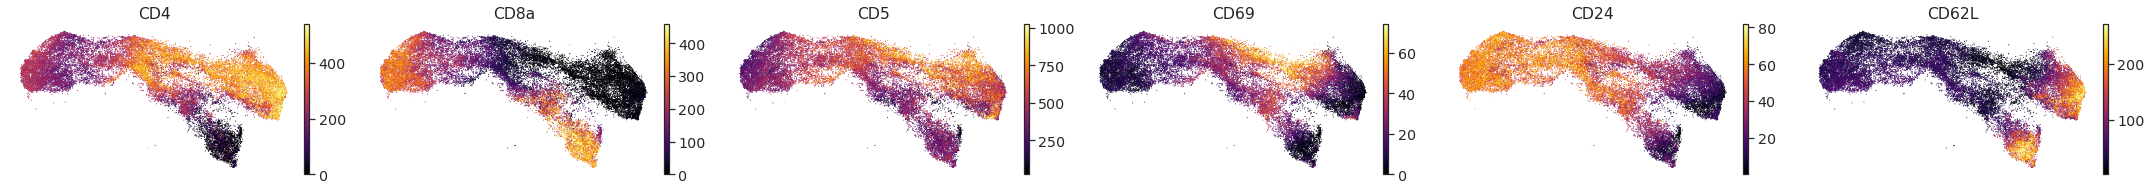

In [58]:
fig, ax_arr = plt.subplots(1,6, figsize = (5*6, 2.75))
titles = ["CD4", "CD8a", "CD5", "CD69", "CD24", "CD62L"]

for i, protein in enumerate(["ADT_CD4_A0001", 'ADT_CD8a_A0002', "ADT_CD5_A0111", "ADT_CD69_A0197", "ADT_CD24_A0212", "ADT_CD62L_A0112"]):
    sc.pl.umap(
        protein_adata, 
        use_raw = False,
        color=protein, 
        ncols=1, 
        color_map = "inferno",
        frameon = False,
        ax = ax_arr.flat[i],
        vmax = "p99.5",
        vmin = "p0.5",
        show = False,
        title = titles[i]
    )
    
    plt.tight_layout()
    
fig.savefig("/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/Annotation_thymus/figures/markers_UMAP_protein.pdf", 
           dpi=DPI, bbox_inches='tight')